# Data Cleaning and Preprocessing

In [1]:
import pandas as pd
import os
import requests
import time
import numpy as np
from sklearn import preprocessing

In [2]:
path="D:/CDS513/Assignment 1/input"    
os.chdir(path)

# Read csv data file
# Data without feature standardization
df = pd.read_csv('steam-200k.csv', header=None)

#  Exploring Dataset

In [3]:
df.head()

,0,1,2,3,4
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [4]:
df.drop(columns =[4],inplace =True)

In [5]:
df.duplicated().sum()

707

In [6]:
df.shape

(200000, 4)

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
# Giving df column names
df.columns = [
    'User-id',
    'Game-title',
    'Mode',
    'Playtime'
]
df.set_index('User-id', inplace=True)

In [9]:
df.head()

,Game-title,Mode,Playtime
User-id,,,
151603712,The Elder Scrolls V Skyrim,purchase,1.0
151603712,The Elder Scrolls V Skyrim,play,273.0
151603712,Fallout 4,purchase,1.0
151603712,Fallout 4,play,87.0
151603712,Spore,purchase,1.0


In [10]:
df.nunique()

Game-title    5155
Mode             2
Playtime      1593
dtype: int64

In [11]:
df['Mode'].value_counts()

purchase    128804
play         70489
Name: Mode, dtype: int64

<Axes: >

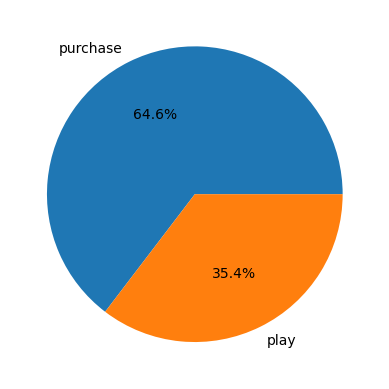

In [12]:
df['Mode'].value_counts().plot(kind ='pie',autopct = '%1.1f%%', ylabel="")

<Axes: >

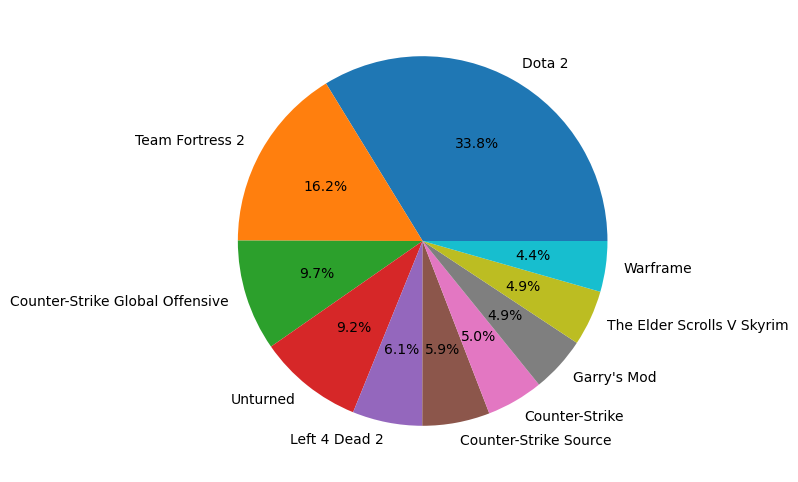

In [13]:
df['Game-title'].value_counts().head(10).plot(kind = 'pie',figsize =(10,6), autopct = '%1.1f%%', ylabel="")

In [14]:
# Pivot the DataFrame to transform 'purchase' and 'play' modes into separate columns
pivot_df = df.pivot_table(index=['User-id', 'Game-title'], columns='Mode', values='Playtime', fill_value=0)

# Reset the index to turn multi-index into columns
pivot_df = pivot_df.reset_index()

# Rename columns for clarity
pivot_df.columns = ['User-id', 'Game-title', 'Playtime', 'Purchase']

# Display the transformed DataFrame
pivot_df.head()

,User-id,Game-title,Playtime,Purchase
0,5250,Alien Swarm,4.9,1
1,5250,Cities Skylines,144.0,1
2,5250,Counter-Strike,0.0,1
3,5250,Counter-Strike Source,0.0,1
4,5250,Day of Defeat,0.0,1


In [15]:
# Saving Checkpoint
pivot_df.to_csv("cleaned_df.csv", index=False)

# Deriving Ratings

In [16]:
df = pd.read_csv("cleaned_df.csv")

In [17]:
df.head()

,User-id,Game-title,Playtime,Purchase
0,5250,Alien Swarm,4.9,1
1,5250,Cities Skylines,144.0,1
2,5250,Counter-Strike,0.0,1
3,5250,Counter-Strike Source,0.0,1
4,5250,Day of Defeat,0.0,1


In [18]:
# purging game library that has less than 2 hours
df = df[(df['Playtime']>=2)]
df.drop(columns ='Purchase',inplace = True )
df.head()

,User-id,Game-title,Playtime
0,5250,Alien Swarm,4.9
1,5250,Cities Skylines,144.0
6,5250,Deus Ex Human Revolution,62.0
17,5250,Portal 2,13.6
21,76767,Age of Empires II HD Edition,13.1


In [19]:
df['Game-title'].nunique()

2800

## Binning playtime into personal-ratings 

In [20]:
avg_playtime = df.groupby(['Game-title'],as_index = False).Playtime.mean()
avg_playtime['avg_playtime'] = avg_playtime['Playtime']
avg_playtime.drop(columns ='Playtime',inplace = True )

In [21]:
avg_playtime.head()

,Game-title,avg_playtime
0,1... 2... 3... KICK IT! (Drop That Beat Like a...,6.20
1,10 Second Ninja,5.40
2,"10,000,000",3.60
3,100% Orange Juice,17.90
4,12 Labours of Hercules,5.75


In [22]:
df = df.merge(avg_playtime, on='Game-title')

In [23]:
df.head()

,User-id,Game-title,Playtime,avg_playtime
0,5250,Alien Swarm,4.9,9.311921
1,975449,Alien Swarm,9.8,9.311921
2,1950243,Alien Swarm,3.8,9.311921
3,2259650,Alien Swarm,3.2,9.311921
4,2753525,Alien Swarm,3.2,9.311921


In [24]:
def assign_rating(row):
    ratios = row['Playtime'] / row['avg_playtime']
    if ratios >= 0.8:
        return 5
    elif ratios >= 0.6:
        return 4
    elif ratios >= 0.4:
        return 3
    elif ratios >= 0.2:
        return 2
    else:
        return 1

In [25]:
df['personal-rating'] = df.apply(assign_rating, axis=1)

# Dropping irrelevant columns
df.drop(columns=['Playtime', 'avg_playtime'], inplace=True)
df.head()
df.to_csv("Data_Score.csv", index=False)

# Getting Additional Info for each Game-title

In [26]:
path="D:/CDS513/Assignment 1/input"
    
os.chdir(path)

df = pd.read_csv('Data_Score.csv')
df.head()

,User-id,Game-title,personal-rating
0,5250,Alien Swarm,3
1,975449,Alien Swarm,5
2,1950243,Alien Swarm,3
3,2259650,Alien Swarm,2
4,2753525,Alien Swarm,2


### Using IGDB API to retrieve additional information for game-title

In [27]:
# IGDB API endpoint for games
url = 'https://api.igdb.com/v4/games'
client_id = 'sxiuj4y04yliue4d66h7dkoxt3sjjf'
access_token = '1cbmp8sdcj79eva95hnqavj7f0ocib'
headers = {
    'Client-ID': client_id,
    'Authorization': f'Bearer {access_token}',
    'Accept': 'application/json'
}

In [28]:
def search_games(titles, batch_size=600):
    # Prepare to collect genres and descriptions
    genres_dict = {}
    count=0

    # Process in batches to manage API request volume
    for i in range(0, len(titles), batch_size):
        batch_titles = titles[i:i+batch_size]
        # Constructing the body for multiple searches can be complex because IGDB API may not support multiple searches in one request.
        # Here we handle them one by one in a batch loop for demonstration.
        for title in batch_titles:
            count+=1
            print(str(count),"/", len(titles)," Requesting", title)
            body = f'search "{title}"; fields name, genres.name, summary; limit 100;'
            response = requests.post(url, headers=headers, data=body)
            if response.status_code == 200:
                data = response.json()
                if data:
                    game_info = {
                        'genre': data[0]['genres'][0]['name'] if 'genres' in data[0] and data[0]['genres'] else 'Genre not found',
                        'summary': data[0]['summary'] if 'summary' in data[0] else 'Summary not found'
                    }
                    print(game_info,'\n')
                    genres_dict[title] = game_info
                else:
                    genres_dict[title] = {'genre': 'Genre not found', 'summary': 'Summary not found'}
            else:
                print(f'API request failed with status code {response.status_code}')
            
    return genres_dict

#### API Request for 2800 games (>1 hour(s))

In [29]:
# Original Code
game_titles = df['Game-title'].unique().tolist()
print(game_titles, "\n\nNumber of unique Game-titles:", np.count_nonzero(game_titles))

genres_info = search_games(game_titles) 
print(genres_info)

['Alien Swarm', 'Cities Skylines', 'Deus Ex Human Revolution', 'Portal 2', 'Age of Empires II HD Edition', 'Banished', 'Call of Duty Black Ops', 'Call of Duty Black Ops - Multiplayer', 'Call of Duty Modern Warfare 2', 'Call of Duty Modern Warfare 2 - Multiplayer', 'Call of Duty Modern Warfare 3', 'Call of Duty Modern Warfare 3 - Multiplayer', 'Call of Duty World at War', 'Counter-Strike', 'Counter-Strike Global Offensive', 'Counter-Strike Source', 'Rise of Nations Extended Edition', 'Thief Deadly Shadows', 'Total War ATTILA', 'Audiosurf', 'Far Cry 3', 'Killer is Dead', 'Left 4 Dead 2', 'The Elder Scrolls V Skyrim', 'Torchlight II', 'XCOM Enemy Unknown', 'Counter-Strike Condition Zero', 'Half-Life 2 Episode One', 'Half-Life 2 Episode Two', 'Worms Reloaded', '7 Days to Die', 'ARK Survival Evolved', 'Amnesia The Dark Descent', 'Armikrog', 'Batman Arkham Origins', 'BioShock Infinite', 'Borderlands', 'Borderlands 2', 'Broken Age', 'Brothers - A Tale of Two Sons', 'Bulletstorm', 'Castle Cras

{'genre': 'Shooter', 'summary': "Alien Swarm is a game and Source SDK release from a group of talented designers at Valve who were hired from the Mod community.\n\nAvailable free of charge, the game thrusts players into an epic bug hunt featuring a unique blend of co-op play and squad-level tactics. With your friends, form a squad of four distinct IAF Marine classes. Plan your attack using an unlockable arsenal of weapons with countless loadout configurations against a wide variety of aliens. Blaze your way through an overrun, off-world colony, eradicating the alien infestation in environments ranging from the icy planet's surface, to a subterranean lava-flooded mining facility.\nAlong with the game get the complete code base for Alien Swarm that features updates to the Source engine as well as the SDK. Alien Swarm adds 3rd person camera, depth of field, improved dynamic shadows and a wide variety of gameplay additions to the Source engine."} 

2 / 2800  Requesting Cities Skylines
{'ge

{'genre': 'Shooter', 'summary': "In the third instalment of the Thief series, master-thief Garrett is contacted by Keeper Artemus with a mission to steal two valuable artefacts. At the same time, Garrett learns about a prophecy: the coming of a Dark Age. He embarks upon a journey to unravel a mystery that threatens the existence of the order of Keepers. Is it possible that there is a traitor in their midst?\n\nThe stealth and thievery game, Thief: Deadly Shadows comes with a number of improvements over two previous parts. Released in 2004, it left behind the aging Dark Engine, using a heavily modified Unreal engine instead. Realistic lighting effects have been implemented: each character and object now casts its own shadow. A third person's view has been made available in addition to the standard first person perspective.\n\nThe stealth system that made Thief: The Dark Project and Thief 2: The Metal Age famous is still in place. You have to stick to the shadows and avoid making noise, 

{'genre': 'Point-and-click', 'summary': 'Armikrog is a unique stop motion clay animated point and click adventure game from the creators of Earthworm Jim and the Neverhood. Follow the adventures of space explorer Tommynaut and his blind alien talking dog Beak-Beak, as they unravel the mysteries of the fortress that holds them captive through exploration and puzzle solving.'} 

35 / 2800  Requesting Batman Arkham Origins
{'genre': 'Fighting', 'summary': "A free-to-play fighting video game for mobile that follows the same premise as the main versions of Arkham Origins.\n\nPlay as Batman as he fights his way through Gotham City's most dangerous locales and encounters a number of DC Comics' most deadly assassins. As you progress, you'll be able to upgrade your character's skills and fighting tactics, but you'll also be able to unlock a number of unique Batsuits by earning in-game currency and rewards."} 

36 / 2800  Requesting BioShock Infinite
{'genre': 'Shooter', 'summary': 'BioShock Inf

{'genre': 'Shooter', 'summary': "The player is drawn into the world of Dead Island on the brink of a mysterious epidemic that suddenly, and without warning, breaks out on the fictional island of Banoi. As a guest of the Royal Palms Resort, the player's stay was supposed to be a dream holiday; a luxurious getaway to the beautiful beaches of a tropical paradise. But faced with the reality of a zombie apocalypse, there is only one thing left to do: Survive. This is Dead Island; a paradise to die for."} 

49 / 2800  Requesting Dishonored
{'genre': 'Puzzle', 'summary': 'Dishonored is an immersive first-person action game that casts you as a supernatural assassin driven by revenge. With Dishonored’s flexible combat system, creatively eliminate your targets as you combine the supernatural abilities, weapons and unusual gadgets at your disposal. Pursue your enemies under the cover of darkness or ruthlessly attack them head on with weapons drawn. The outcome of each mission plays out based on t

{'genre': 'Simulator', 'summary': "Garry's Mod is a physics sandbox. There aren't any predefined aims or goals. We give you the tools and leave you to play.\n\nYou spawn objects and weld them together to create your own contraptions - whether that's a car, a rocket, a catapult or something that doesn't have a name yet - that's up to you. You can do it offline, or join the thousands of players who play online each day.\n\nIf you're not too great at construction - don't worry! You can place a variety of characters in silly positions. But if you want to do more, we have the means."} 

61 / 2800  Requesting Gone Home
{'genre': 'Point-and-click', 'summary': "A first-person exploratory game taking place in 1995 in which Katie, a university student back from Europe, arrives at her family's newly inherited mansion only to find nobody there, with a note from her younger sister Sam suggesting that she's left home. Katie must explore the mansion to put together the stories of where her parents ha

{'genre': 'Platform', 'summary': 'Mark of the Ninja is a side-scrolling action stealth video game developed by Klei Entertainment and published by Microsoft Studios. It was announced on February 28, 2012 and later released for the Xbox 360 via Xbox Live Arcade on September 7, 2012. A Microsoft Windows version was released on October 16, 2012. It follows the story of a nameless ninja in the present day, and features a themed conflict between ancient ninja tradition and modern technology. Cutscenes for the game are rendered in Saturday morning cartoon animation style.'} 

74 / 2800  Requesting Mass Effect 2
{'genre': 'Shooter', 'summary': 'Firewalker Pack is a DLC pack for Mass Effect 2.'} 

75 / 2800  Requesting Max Payne 3
{'genre': 'Shooter', 'summary': 'Max Payne 3 is a third-person shooter in which the player assumes the role of its titular character, Max Payne. A new feature to the series, introduced in Max Payne 3, is the cover system, which allows players to gain a tactical advan

{'genre': 'Turn-based strategy (TBS)', 'summary': 'An online card RPG game released in 1998 for the PC.'} 

91 / 2800  Requesting Serious Sam 3 BFE
{'genre': 'Shooter', 'summary': 'Serious Sam 3: BFE is a first-person action shooter, a glorious throwback to the golden age of first-person shooters where men were men, cover was for amateurs and pulling the trigger made things go boom.\n\nServing as a prequel to the original game, Serious Sam: The First Encounter, Serious Sam 3 takes place during the Earth’s final struggle against Mental’s invading legions of beasts and mercenaries.'} 

92 / 2800  Requesting Shadowrun Dragonfall - Director's Cut
{'genre': 'Role-playing (RPG)', 'summary': "Shadowrun: Dragonfall - Director’s Cut is a standalone release of Harebrained Schemes' critically-acclaimed Dragonfall campaign, which first premiered as a major expansion for Shadowrun Returns. The Director's Cut adds a host of new content and enhancements to the original game: 5 all-new missions, alter

{'genre': 'Point-and-click', 'summary': "The Walking Dead: Season One (also known as The Walking Dead: The Game) is an episodic interactive drama graphic adventure video game developed and published by Telltale Games. Based on Robert Kirkman's The Walking Dead comic book series, the game consists of five episodes, released between April and November 2012. It is available for Android, iOS, Kindle Fire HDX, Microsoft Windows, Mac OS X, PlayStation 3, PlayStation Vita, Xbox 360, PlayStation 4 and Xbox One. The game is the first of The Walking Dead video game series published by Telltale."} 

105 / 2800  Requesting The Witcher 2 Assassins of Kings Enhanced Edition
{'genre': 'Role-playing (RPG)', 'summary': 'All existing owners of The Witcher 2 received free upgrades to the Enhanced Edition, and could pre-load the update starting 11 April 2012. All new copies on PC and Xbox 360 shipped with the additional content on board. The Witcher 2: Assassins of Kings - Enhanced Edition added over 10GB

{'genre': 'Point-and-click', 'summary': "Venture into the realm of a madman to free your beloved from captivity in this hidden object adventure! As reporter Sam Wilde, you must work quickly to unravel a bizarre series of disappearances involving young and beautiful people. Sam's every move is being tracked so he has to be extra careful. Putting his journalistic talents to the test, Sam must find the maniac who has kidnapped Anna, and stop him before it's too late."} 

123 / 2800  Requesting Battlefield Bad Company 2
{'genre': 'Shooter', 'summary': 'Battlefield: Bad Company 2 brings the award-winning Battlefield gameplay to the forefront of PC gaming with best-in-class vehicular combat and unexpected "Battlefield moments."\n\nNew vehicles like the ATV and a transport helicopter allow for all-new multiplayer tactics on the Battlefield. With the Frostbite-enabled Destruction 2.0 system, you can take down entire buildings and create your own fire points by blasting holes through cover. You

{'genre': 'Puzzle', 'summary': "Enter the Darwinian world of a galactic mote. Grow by absorbing smaller motes—but beware of being absorbed yourself.\nOsmos+ features unique physics-based play, stellar graphics, and a hypnotic ambient soundtrack.\nNavigate through floating playgrounds, competitive petri dishes, deep solar systems, and more.\nThe key is to balance mass and movement: to propel yourself you must eject matter behind you, causing you to shrink. Use it wisely.\nWhether you're a child at heart who likes mucking about with single-cell organisms, or a strategist with a physics degree, this game is for you."} 

143 / 2800  Requesting Portal
{'genre': 'Real Time Strategy (RTS)', 'summary': "Warcraft II: Beyond the Dark Portal is an expansion pack for Warcraft II: Tides of Darkness. After defeating the Orcish Horde and capturing the survivors, the Human Alliance attempts to destroy the Dark Portal. However, whilst they destroy the portal, the rift that joins the Orcs' world of Drae

{'genre': 'Real Time Strategy (RTS)', 'summary': 'Company of Heroes: Tales of Valor is the expansion to the Game of the Year winner and highest rated real time strategy franchise Company of Heroes. Featuring new campaigns to overcome, units to command, and battlefields to conquer, Company of Heroes: Tales of Valor delivers evolved gameplay mechanics and 3 episodic adventures including 9 new missions, 3 new Multiplayer Modes, and new abilities to master.'} 

156 / 2800  Requesting Might & Magic Heroes VI
{'genre': 'Role-playing (RPG)', 'summary': 'The adventure in Heroes VI, starting 400 years before events in Heroes V, catapults a family of heroes into a fast-paced epic story where Angels plot to end -- once and for all -- an unfinished war with their ancient rivals, the Faceless.\nA legendary Archangel General is resurrected, but with his powers crippled. Plagued by horrible memories of the Elder Wars, he plots to recover his powers and take control of Ashan while destroying both Face

{'genre': 'Real Time Strategy (RTS)', 'summary': 'A tower defense game where you have to defend Power Cores from being stolen. Tower construction is limited to specified platforms on where you can place 1 out of 10 diffrent upgradeable towers. Towers can not be destroyed by the enemies. Tower placement is key to progress in this game as they each have pros and cons. During the game you battle a variety of 15 diffrent "Insectoid" enemies with various abilitys to handle such as stealth, speed, armor and shields etc. The invaders can carry 1-3 powercores as they reach the powerstations and try to make their escape.'} 

173 / 2800  Requesting Deus Ex Human Revolution - The Missing Link
{'genre': 'Shooter', 'summary': 'The Missing Link is the first and only standalone downloadable episode add-on for Deus Ex: Human Revolution; it explains what happened to Adam Jensen during his three-day disappearance after he left Hengsha a second time.'} 

174 / 2800  Requesting Dota 2
{'genre': 'Strategy'

{'genre': 'Shooter', 'summary': 'Orcs Must Die! is a strategy video game developed by Robot Entertainment. It is a Tower defense game that eschews the traditional top-down view of similar games, instead using a third-person action-oriented viewpoint.'} 

192 / 2800  Requesting PAYDAY The Heist
{'genre': 'Shooter', 'summary': 'Payday: The Heist is an action filled first person shooter that lets players take on the role of a hardened career criminal executing intense, dynamic heists in constant pursuit of the next “big score”. Load out with an array of weaponry and equipment. Navigate six high-stake heists with three other live or A.I. Co-Op partners in crime.'} 

193 / 2800  Requesting Plain Sight
{'genre': 'Fighting', 'summary': 'Plain Sight is an indie game that utilises basic mechanics and plays on them greatly, usually involving charging up attacks and gravity shifting as your jump around the levels. It is practically "a game about suicidal ninja robots".'} 

194 / 2800  Requesting 

{'genre': 'Shooter', 'summary': 'The Typing of the Dead: Overkill fuses the horror and comedy of the legendary House of the Dead series with unique typing mechanics in order to deliver a truly original gaming experience! This gruesome shooter puts you in the middle of a mutant outbreak in Bayou county. Blast pieces out of the zombie horde across 9 stages, one keystroke at a time, in order to save you and a friends life as you work to uncover the mystery behind the outbreak.'} 

212 / 2800  Requesting Titan Quest Immortal Throne
{'genre': 'Role-playing (RPG)', 'summary': 'Titan Quest: Immortal Throne is an expansion to the 2006 action role-playing hack and slash video game Titan Quest developed by Iron Lore Entertainment. Like Titan Quest, Immortal Throne is a single player and multiplayer game taking place in a fantastic world based on Greek mythology.'} 

213 / 2800  Requesting Total War SHOGUN 2
{'genre': 'Strategy', 'summary': 'Bolster your Sengoku-era forces with Saints and Heroes,

{'genre': 'Real Time Strategy (RTS)', 'summary': "Get ready for an epic journey to defend your kingdom against hordes of orcs, trolls, evil wizards and other nasty fiends using a vast arsenal of towers and spells at your command!\n\nFight on forests, mountains and wastelands, customizing your defensive strategy with different tower upgrades and specializations! Rain fire upon your enemies, summon reinforcements, command your troops, recruit elven warriors and face legendary monsters on a quest to save the Kingdom from the forces of darkness!Key Features\nEpic defense battles that will hook you for hours!\nCommand your soldiers and see them engage in hand to hand cartoon battles!\nFull screen High definition awesome illustrated cartoon art!\n8 specialized tower upgrades to customize your strategy! Mighty Barbarians, Arcane Wizards, Forest Rangers to name a few.\nOver 18 tower abilities! Have your Sorcerers summon earth elementals and polymorph your enemies!\nOver 45 different enemies, f

{'genre': 'Role-playing (RPG)', 'summary': 'The shadows of destruction begin to loom on the horizon once a human mage uncovers a dark and powerful secret dating back to the remote past of the Elven race.'} 

235 / 2800  Requesting FEZ
{'genre': 'Genre not found', 'summary': 'The cancelled sequel to the original Fez.'} 

236 / 2800  Requesting FlatOut 2
{'genre': 'Racing', 'summary': "Experience the drive of your life as you throw yourself around on and off the track causing fences to shatter, tyre walls explode, water tanks and barrels fly across the track into other cars. And if anyone, including you, gets caught up in a big smash sit back and watch as the driver gets catapulted through the windscreen in spectacular effect. With over 5000 destructible objects on each track and 40 deformable pieces on every car sparks are guaranteed to fly increasing the mayhem with every lap! \u2028\u2028\n\nFeaturing an enhanced version of the original's lauded physics engine and even faster driving 

{'genre': 'Puzzle', 'summary': 'New adventure game with gawky handymen from the legendary series. "Pat & Mat" is puzzle adventure game for everyone. All settings are based on the popular TV stop-motion series about "Pat & Mat", two handymen. Although the game is fully 3D rendered in real-time, it still keeps the dreamy look of stop-motion movies (characters are modeled in “puppet-style” and animations simulate “stop-motion“ animation process). Player is taking control of both Pat & Mat and solve various tasks by cooperation and help of both characters.and non-typical puzzle solving.'} 

250 / 2800  Requesting Rayman Legends
{'genre': 'Platform', 'summary': 'The Glade of Dreams is in trouble once again! The nightmares multiplied and spread, creating new monsters even more terrifying than before!'} 

251 / 2800  Requesting Red Orchestra Ostfront 41-45
{'genre': 'Shooter', 'summary': "Fight in the theatre of war that changed the world forever. Battle alongside your compatriots on some of 

{'genre': 'Platform', 'summary': 'Three Heroes survive in countless dangers in a fairy-tale world, with physics-based jigsaw puzzles, beautiful scenery, and cooperative online mode.'} 

266 / 2800  Requesting Ultimate General Gettysburg
{'genre': 'Real Time Strategy (RTS)', 'summary': 'Ultimate General: Gettysburg is a Tactical Battle Simulator that allows you to lead thousands of soldiers in the famous Battle of Gettysburg as commander of either the Union or Confederate army. The game features the most accurately created map, complex morale, innovative control mechanics and smart AI. You have the freedom to use different strategies while the battle progresses. Your decisions and military performance play a crucial role in the result. Lead your army and win the Battle of Gettysburg!'} 

267 / 2800  Requesting Warhammer 40,000 Dawn of War II
{'genre': 'Real Time Strategy (RTS)', 'summary': "With a focus on fast-action RTS gameplay, Dawn of War II brings to life the science fiction unive

{'genre': 'Role-playing (RPG)', 'summary': "Once exclusive to a select group of our Kickstarter backers, the Musketeer is now FREE DLC for all Darkest Dungeon owners! She is a complete, studio quality, re-skin of the Arbalest class. A celebrated competitive sharpshooter, The Musketeer arrives in the Hamlet, determined to prove her skill after a disappointing tournament. She aims to become a legend in hunting circles by putting her skills to the test against the terrifying beasts and unnameable abominations that roam the Ancestor's Estate!"} 

287 / 2800  Requesting Dungeon of the Endless
{'genre': 'Role-playing (RPG)', 'summary': 'Endless Dungeon is a Rogue-lite Tactical Action game, set in the award-winning Endless universe. Recruit a team of shipwrecked heroes, plunge into a long-abandoned space station, and protect your crystal against never-ending waves of monsters… or die trying, get reloaded, and try again.'} 

288 / 2800  Requesting Hero Academy
{'genre': 'Strategy', 'summary': 

{'genre': 'Simulator', 'summary': 'Sid Meier\'s Civilization IV: Warlords is the first expansion pack for the award-winning game that has become an instant world-wide hit. Paying homage to some of history\'s greatest military leaders, the expansion delivers six unique and interesting scenarios, giving players the chance to change the course of history with the help of their new powerful "warlord" unit. Civ IV: Warlords includes new civilizations, leaders, units, and wonders that offer even more fun and exciting ways for players to expand their civilization\'s military power as they strive for world domination.\n\nGame scenarios: the expansion delivers eight scenarios.\n\nNew civilizations: the pack provides six new civilizations and associated unique units.\nCivilization leaders: 10 new leaders, including leaders for the new civilizations as well as additional leaders for existing civilizations.'} 

307 / 2800  Requesting South Park The Stick of Truth
{'genre': 'Role-playing (RPG)', 's

{'genre': 'Shooter', 'summary': "Black Mesa is a re-envisioning of Valve Software's classic science fiction first person shooter, Half-Life. Powered by Source Engine, You will re-visit the inaugural role of Gordon Freeman and his memorable journey through the Black Mesa Research Facility. Expect detailed environments to explore, a huge cast of characters and experimental weaponry. All-new music, voice acting, choreography and added dialogue give way to a more expansive and immersive experience than ever before."} 

315 / 2800  Requesting Blacklight Retribution
{'genre': 'Shooter', 'summary': "Take firefights to a futuristic new level in Blacklight: Retribution, a free-to-play FPS. See through walls with the HRV, deploy mechanized Hardsuits, and customize your weapons to dominate the opposition.\n\nIn Blacklight, mastering the futuristic tech is half of victory. You'll need to carefully balance your loadout, from the extreme customization possible in designing your firearms, to the equi

{'genre': 'Strategy', 'summary': "The war continues...\nX-COM: UFO Defense brought you to a galactic battlefield. X-COM: Terror from the Deep brings the alien terror into a totally new dimension. Seeking to take advantage of a weakened Earth, X-COM's deep space foes unexpectedly change strategy and launch a powerful second front against planet Earth. In the dark depths of vast oceans, long sleeping forces are awakened by reanimation signals sent out across the galactic silence by their interstellar brothers and sisters. Slowly but surely, an army of hibernating alien sea creatures awakens. Your combat now extends to the strange new worlds of the deep where superior alien technologies threaten the very survival of your planet earth."} 

334 / 2800  Requesting Far Cry 2
{'genre': 'Shooter', 'summary': 'A civil war has swept through the country and you\'re caught in the middle of it. Track down the person at the forefront of the fighting, a ruthless arms dealer known only as "The Jackal".

{'genre': 'Simulator', 'summary': 'IL-2 Sturmovik: Battle of Stalingrad is the continuation of the legendary IL-2 Sturmovik series that has set the standard for combat flight games for more than 10 years. This new entry into the series will offer virtual pilots an even more accurate simulation of the legendary air battles of World War II. A new higher level of physics modeling, damage modeling and aerodynamics has been achieved which allows for far greater realism than in any other title.'} 

346 / 2800  Requesting IL-2 Sturmovik Cliffs of Dover
{'genre': 'Simulator', 'summary': 'Join the Royal Air Force and Battle for Britain! Fly into the pivotal aerial battle for the skies of Britain. As a member of the British RAF, face off against the deadly German Luftwaffe and the Italian air forces.'} 

347 / 2800  Requesting Insurgency
{'genre': 'Shooter', 'summary': "Take to the streets for intense close quarters combat, where a team's survival depends upon securing crucial strongholds and de

{'genre': 'Shooter', 'summary': "Shoot 'n' loot your way through a brand new adventure that rockets you onto Pandora's moon in Borderlands: The Pre-Sequel. Discover the story behind Borderlands 2’s villain, Handsome Jack, and his rise to power in this brand new game in the Borderlands series. Taking place between the original Borderlands and Borderlands 2, the Pre-Sequel gives you a whole lotta new gameplay featuring the genre fusion of shooter and RPG gameplay that players can’t get enough of.\n\nGet high in low gravity and launch across the moonscape to take enemies down from above using new ice and laser weapons. Catch-a-ride on the lunar landscape with new vehicles equipped with deadly weapons allowing for more levels of destructive mayhem. So grab a friend (or two, or three), strap on a rocket, and take off on a brand new Borderlands adventure"} 

366 / 2800  Requesting Assetto Corsa
{'genre': 'Racing', 'summary': "The Intercontinental GT Pack DLC introduces 4 iconic international

{'genre': 'Role-playing (RPG)', 'summary': "As characters gain levels, they gain a passive stat increase for stats that help that particular character and gain power points, allowing the player to further define the abilities of that character. Each character has three power trees that they can spend points. Each of the trees generally focuses on a certain mechanic or play style, such as Iron Man's shields, Hawkeye's trick arrows, or Deadpool's guns. As the character gains levels the player has access to more skills to spend points on and is able to put more points into existing skills. Each skill has a level cap, so more points cannot be put in a skill until a certain level is reached."} 

381 / 2800  Requesting Sins of a Dark Age
{'genre': 'Real Time Strategy (RTS)', 'summary': "Sins of a Dark Age is a dark fantasy spin on the MOBA genre. Explore your inventory, equip your Hero and enter a world full of decisive team battles, tide-turning quests, treasured rewards, crafted goods, and

{'genre': 'Role-playing (RPG)', 'summary': 'Rift (previously known as Rift: Planes of Telara) is a fantasy free-to-play massively multiplayer online role-playing game (MMORPG) developed by Trion Worlds. Rift takes place within the fantasy world of Telara. The game was released in March 2011. \n \nTwo competing factions composed of a selection of races and classes battle each other; as well as the enemies who emerge from dynamic rifts.'} 

396 / 2800  Requesting Remember Me
{'genre': 'Strategy', 'summary': 'A psychological horror game and visual novel that will test your morality, your ability to adapt, and your willpower to remain sane under pressure...'} 

397 / 2800  Requesting SolForge
{'genre': 'Role-playing (RPG)', 'summary': "SolForge is a free-to-play digital collectible game in which players construct their own decks to challenge their friends or battle against the computer. The current open beta version includes deckbuilding, collection management, online play, AI opponents, t

{'genre': 'Shooter', 'summary': 'Defiance is the first multi-platform massive online shooter video game that is also a ground-breaking entertainment experience, interconnecting with a global television program on Syfy. The game combines the intense action of a third-person shooter, with the persistence and scale of a massive online game, while its TV counterpart exudes the scope, story, and drama of a classic sci-fi epic.Being developed for the PC, Xbox 360 video game and entertainment system from Microsoft, and PlayStation3 computer entertainment system, Defiance unites multiple game genres across the most popular platforms.'} 

408 / 2800  Requesting Fallout 3 - Game of the Year Edition
{'genre': 'Shooter', 'summary': 'Prepare for the Future with Fallout 3: Game of the Year Edition, experience the most acclaimed game of 2008 like never before. Create a character of your choosing and descend into an awe-inspiring, post-apocalyptic world where every minute is a fight for survival.'} 



{'genre': 'Role-playing (RPG)', 'summary': 'Gather your heroes and journey beyond the dungeons of Castle Hammerwatch to explore a pixelated world like never before. Aid King Roland’s resistance while helping villagers along the way. Battle beasts, finish off hordes of the undead, and face the forces of evil in this epic ode to classic ARPG.'} 

428 / 2800  Requesting Hand Of Fate
{'genre': 'Role-playing (RPG)', 'summary': 'Hand of Fate 2 is a dungeon crawler set in a world of dark fantasy. Master a living boardgame where every stage of the adventure is drawn from a deck of legendary encounters chosen by you! Choose wisely - your opponent, the enigmatic Dealer, will pull no punches as he shapes you into the instrument of his revenge.\n\nThe table has changed, but the stakes remain the same: life or death!\n\nKEY GAME FEATURES\n\nA world transformed - 100 years have passed since the Dealer was usurped and the Game of Life and Death gained a new master.\n\n22 exciting new challenges that 

{'genre': 'Role-playing (RPG)', 'summary': 'Darker Purpose is a top-down, rogue-like action RPG that combines the ingenuity of genre-defining classics with the expansiveness and accessibility of modern day action adventure games. The gameplay is steeped in a variety of influences ranging from A Link to the Past to The Binding of Isaac to Diablo. We love games with great mechanics and awesome, bizarre storylines, and that’s what we’re creating with Our Darker Purpose.'} 

439 / 2800  Requesting Rampage Knights
{'genre': 'Fighting', 'summary': "Rampage Knights is a cooperative beat 'em up game mixed up with randomized dungeon crawling and exploration which you can play alone or with a friend online.\n\nYou play as a hero trapped by a spell in a magical forest. All paths lead you to a nearby ruined castle, infested with goblins, skeletons and other foul creatures. Gear up with awesome and ridiculous weapons and spells and descend into the deep labyrinth below the ruin to face its sinister

{'genre': 'Role-playing (RPG)', 'summary': 'Nemesis, Goddess of Retribution, is out of control. She is corrupting the Threads of Fate and punishing all those who oppose her. Take up your weapon, fight alongside gods, and change fate itself in Titan Quest 2, an action RPG inspired by Greek mythology.'} 

453 / 2800  Requesting Tom Clancy's Splinter Cell Double Agent
{'genre': 'Shooter', 'summary': "In the highly anticipated sequel, Tom Clancy's Splinter Cell: Double Agent, play as a double agent spy for the first time ever. Take on dual roles of covert operative and ruthless terrorist, where your choices of whom to betray and whom to protect actually affect the outcome of your game. This is the Ubisoft Montreal version, which plays more like the classic Splinter Cell games. The games share the same general plot but feature different storylines, plot twists, and levels. They do however, share the same background music, a few cut scenes and all voice actors."} 

454 / 2800  Requesting The

{'genre': 'Real Time Strategy (RTS)', 'summary': 'Only a few thousand humans managed to escape from the Earth before its collapse in 2150 A.D. They spent the next few years on the terra forming of the red planet, developing new technologies and building up new civilisations. Somehow each of the three fractions "Eurasian Dynasty", "United Civilised States" and "Lunar Corporation" did this independently and separately from each other - but in the year 2160 something strange happens in this new world. Will the ED, UCS and LC join forces or continue their old war against each other?\n\nBesides the usual venues in the solar system, there are some strange looking locations: planets with moving and reflecting liquid surfaces. And beside the standard RTS - resources acquisition, base building and destruction of enemy bases, the year 2160 will have some adventure inspired tasks for the players.'} 

469 / 2800  Requesting Evil Genius
{'genre': 'Adventure', 'summary': "As you complete dozens of n

{'genre': 'Shooter', 'summary': "In Mad Max, the player takes on the role of titular character Mad Max; a dangerous melee fighter and can use his attacks to kill almost anyone. His weapon of choice is his shotgun. He is assisted by another man called Chumbucket. Chum mainly works with Max to build and upgrade the Magnum Opus vehicle.\n\nMad Max will feature a variety of weapons which Max can use to defeat enemies. Though the shotgun is Max's weapon of choice, ammo is scarce, and so melee options are the smarter way to go. The 'thunderstick' is an explosive weapon that can be lanced into an enemy's chest, crackling like a lit dynamite fuse before blowing the victim to smithereens. The Harpoon is also one of Max's favorite weapon though it can only be used in-vehicle with Chum riding along. Max's Magnum Opus can be combined with a speedy V12 engine and powerful ramming ability to destroy enemies's vehicles and weaponry. When simultaneously driving and aiming, the game enters slow-motion 

{'genre': 'Racing', 'summary': 'Bring the true driver’s experience to life with all the intensity and exhilaration of being behind the wheel!'} 

494 / 2800  Requesting SpellForce 2 Gold Edition
{'genre': 'Real Time Strategy (RTS)', 'summary': 'Experience the age of heroes: roleplaying action & realtime strategy in a perfect mix of genres.'} 

495 / 2800  Requesting Star Wars - Jedi Knight II Jedi Outcast
{'genre': 'Shooter', 'summary': "In the tradition of the highly acclaimed Star Wars: Jedi Knight series, Star Wars: Jedi Knight 2, Jedi Outcast features rebel agent Kyle Katarn in exhilarating first-person action. Several years have passed since Kyle avenged his father's death and saved the Valley of the Jedi from Jerec and his band of Dark Jedi. Allowing his Force powers to languish for fear of falling to the dark side, Kyle entrusted his lightsaber to Luke Skywalker, vowing never to use it again. But when a new and menacing threat to the galaxy emerges, Kyle knows he must reclaim hi

{'genre': 'Adventure', 'summary': 'Engage in a terrifying quest for survival as you navigate the labyrinthine Sevastopol station. Unprepared and underequipped, you will need all your wits and daring to get out alive.'} 

508 / 2800  Requesting Amnesia A Machine for Pigs
{'genre': 'Puzzle', 'summary': 'From the creators of Amnesia: The Dark Descent and Dear Esther comes a new first-person horrorgame that will drag you to the depths of greed power and madness. It will bury its snout into your ribs and it will eat your heart.'} 

509 / 2800  Requesting BioShock
{'genre': 'Shooter', 'summary': "The year is 1960 and the player character, Jack, is on board a plane crossing the Atlantic ocean. Things go wrong though and the plane crashes. Jack is lucky though and finds himself outside a lighthouse. This is no ordinary lighthouse however. It leads to Rapture, an Utopian underwater city built by the tycoon Andrew Ryan. It's not long until Jack is contacted by a man called Atlas who offers Jack 

{'genre': 'Strategy', 'summary': 'An indie strategy game for PC and Mac.'} 

526 / 2800  Requesting Medieval II Total War Kingdoms
{'genre': 'Strategy', 'summary': "Medieval II: Total War Kingdoms is the official expansion to last year's award-winning Medieval II: Total War, presenting players with all-new territories to explore, troops to command, and enemies to conquer. \nKingdoms is the most content-rich expansion ever produced for a Total War game, with four new entire campaigns centered on expanded maps of the British Isles, Teutonic Northern Europe, the Middle East, and the Americas. In Medieval II, you were only given a tantalizing glimpse of South America, but in Kingdoms, vast tracts of land in both North and South America have been opened up for you to conquer. All-new factions from the New World are also now fully playable, including the Aztecs, Apaches, and Mayans. \nAlong with the new maps in the Britannia, Teutonic, Crusades, and New World Campaigns, there are 13 new fact

{'genre': 'Role-playing (RPG)', 'summary': 'Choose Your Path! Set 4,000 years before the Galactic Empire, you are the last hope for the Jedi Order and the Republic - can you master the ways of the Force to become their savior? Or will you fall to the dark side and achieve ultimate power? Hero, villain, peacekeeper, or chaos-bringer... you and your party will determine the fate of the galaxy!\n\nStar Wars: Knights of the Old Republic is a role-playing video game. Players will be able to create their own characters and be able to choose what gender, appearance, class, skills, attributes, and feats they have throughout the game - no two characters will be the same!'} 

536 / 2800  Requesting Supreme Commander Forged Alliance
{'genre': 'Real Time Strategy (RTS)', 'summary': 'The Infinite War rages on across the galaxy. Negotiations have failed and our only hope for an end to the destruction is through victory in combat.'} 

537 / 2800  Requesting The Elder Scrolls IV Oblivion 
{'genre': 'R

{'genre': 'Racing', 'summary': 'The game features all eleven teams and twenty-two drivers competing in the 2013 season, as well as the nineteen circuits and Grands Prix. A "Classic Edition" of the game features additional drivers, cars and circuits from the 1980s and 1990s, including the Williams FW07B, FW12, FW14B, FW18, Ferrari F399, F1/87/88C, Lotus 98T, and 100T. Additional circuits include Estoril, Imola, Brands Hatch and Jerez.'} 

553 / 2800  Requesting F1 2015
{'genre': 'Racing', 'summary': 'Race like a champion in F1 2015 and get closer than ever before to the experience of racing in the world’s most glamorous, exciting and prestigious motorsport. F1 2015 puts you in the heart of the action with a stunning new game engine that recreates the blisteringly fast and highly responsive racing cars of Formula One and features all-new ‘broadcast presentation’ that immerses you in the unique race day atmosphere.\n\nCompete as your favourite Formula One star in the new Championship Seas

{'genre': "Hack and slash/Beat 'em up", 'summary': 'Ryse: Son of Rome is a stunning action-adventure that follows Marius Titus on a heroic quest to avenge the death of his family, and preserve the honor of Rome, at all costs.'} 

567 / 2800  Requesting Sherlock Holmes Nemesis
{'genre': 'Point-and-click', 'summary': 'Sherlock Holmes: Nemesis sends us to 19th Century London where Arséne Lupin, a young French burglar with an impressive track record, has just challenged Scotland Yard and the most famous of detectives - Sherlock Holmes.'} 

568 / 2800  Requesting Sherlock Holmes versus Jack the Ripper
{'genre': 'Point-and-click', 'summary': 'Sherlock Holmes is back with an investigation in this adventure game. The famous detective chases against the most threatening serial killer England has ever known - Jack the Ripper.'} 

569 / 2800  Requesting Sniper Elite 3
{'genre': 'Shooter', 'summary': 'Observe. Plan. Execute. Adapt. The latest chapter in the award-winning series, SNIPER ELITE 3 tak

{'genre': 'Sport', 'summary': 'Football Manager 2013 (often abbreviated to Football Manager 13, or more commonly FM13) is a 2012 football management simulation video game developed by Sports Interactive and published by Sega. It was released on Microsoft Windows and OS X on 2 November 2012. Football Manager Handheld 2013 was subsequently published for PlayStation Portable on 30 November, and for iOS and Android on 13 December.'} 

584 / 2800  Requesting Football Manager 2014
{'genre': 'Simulator', 'summary': 'FM 2014 features a rehauled transfer module in which opposing clubs and managers adopt a more realistic approach when making or responding to transfer offers. Additional, a host of new ‘real world’ transfer clauses have been added, such as the facility to loan a player back to the club he has just been bought from and the option to offer a combination of money and loan players, as well as new contract clauses such as a sub bench appearance fee. Beyond this, the old ‘turn-based’ sy

{'genre': 'Platform', 'summary': "The player must balance and control their speed so that they don't fall. There is a clock so that the player is pressured into completing the level faster, The game also has achievements, similar to Xbox 360 achievements. The game's multiplayer features include highscores, ghost challenge (where the user plays against the ghost of any other player in the high score list) and online player profiles with team, country and player statistics. The game uses 3-D graphics, but is played on a 2-D plane, so the player can only move forwards, backwards, up or down (not left or right)."} 

599 / 2800  Requesting Assassin's Creed Brotherhood
{'genre': 'Adventure', 'summary': "A remaster of Assassin's Creed Brotherhood included with Assassin's Creed: The Ezio Collection.\n\nAll the single-player add-on content (Copernicus Conspiracy, The Da Vinci Disappearance) is included and multiplayer is removed."} 

600 / 2800  Requesting Baldur's Gate II Enhanced Edition
{'ge

{'genre': 'Role-playing (RPG)', 'summary': 'A World to Build… or Destroy. “A war is coming… a war between East and West - between Kingdoms and Empires, between man and Fallen. A future of blood and death, of chaos and destruction.” – the Oracle Ceresa.'} 

612 / 2800  Requesting Grand Ages Rome
{'genre': 'Real Time Strategy (RTS)', 'summary': 'After decades in exile, your family name has been all but forgotten in Rome. But the departure of the tyrant Sulla has changed everything, and Rome stands on the brink of a new era.'} 

613 / 2800  Requesting King Arthur - The Role-playing Wargame
{'genre': 'Real Time Strategy (RTS)', 'summary': 'Critically praised by reviewers and gamers alike, King Arthur was received as one of the biggest surprises to emerge on the gaming scene in 2010. Now the Fantasy/Roleplaying RTS returns in a sequel set to push the boundaries of the genre even further. Our story begins long after young Arthur pulled the enchanted sword out of the stone, united the war-tor

{'genre': 'Role-playing (RPG)', 'summary': 'Captain your own space ship and roam the galaxy in 3D in this tactical space simulator with tons of RPG depth ! Space has never looked so inviting - but images can betray...'} 

627 / 2800  Requesting The Guild II Renaissance
{'genre': 'Real Time Strategy (RTS)', 'summary': 'The Guild 2: Renaissance is a strategy game.\nFor centuries Europe has been dominated by the church and nobility. On the shoulders of ordinary people the servants of god and the noble families justified their power and wealth. This was the incontrovertible, divine world order. A truly dark era...'} 

628 / 2800  Requesting The Settlers 7 Paths to a Kingdom - Gold Edition
{'genre': 'Strategy', 'summary': 'Choose your own path to victory in The Settlers 7: Paths to a Kingdom, the long-anticipated sequel to the award-winning strategy game. Embark on an exciting quest to create, build and manage your kingdom in the most innovative, customizable and re-playable version ever!'}

{'genre': 'Point-and-click', 'summary': "The Dream Machine is an award-winning adventure game about dreams and voyeurism. It's built by hand using materials such as clay, cardboard and broccoli."} 

645 / 2800  Requesting The Secret World
{'genre': 'Puzzle', 'summary': 'The Secret World is a massively-multiplayer online world with a unique modern-day setting and unparalleled storytelling. Imagine if every myth, conspiracy theory and urban legend was true--a world where you align with secret societies and face the looming darkness.'} 

646 / 2800  Requesting ArcaniA
{'genre': 'Role-playing (RPG)', 'summary': 'Arcania is a Fantasy Action game set in a rich world where an entire kingdom’s future is at stake Build your strength and learn the skills needed to become a hero as you challenge a mighty king and uncover his dark secrets. Travel through a land of different climate zones, abundant flora and fauna, subterranean vaults, and unique towns and castles where clouds darken the skies, wea

{'genre': 'Shooter', 'summary': 'Quake 4 is a action shooter game which serves as the another chapter in the Quake series.'} 

661 / 2800  Requesting Rocksmith
{'genre': 'Music', 'summary': 'Learn by playing along to your favorite songs featuring real time feedback, customizable pace, and a vast, ever-expanding song library of official recordings all designed to help you express your creativity.'} 

662 / 2800  Requesting Thinking with Time Machine
{'genre': 'Platform', 'summary': "Thinking with Time Machine is a Portal 2 mod in which you will find and use a Time Machine to create a twin of yourself from the past to help you solve the puzzles. The past self accurately repeats all of the player's actions, creating a unique twist on familiar Portal game mechanics."} 

663 / 2800  Requesting 4 Elements
{'genre': 'Puzzle', 'summary': 'The ancient kingdom is in trouble! The magic of the four elements that kept it running for centuries has been corrupted by evil powers and the altars no long

{'genre': 'Genre not found', 'summary': 'Crazy Machines 2 for the DS is the sequel to the well-known puzzle and experiment solving game. The professor is back and leaves his lab to travel around the world this time, to build up new experiments to solve for the player. During his travels he reaches places like beautiful beaches, the Great Wall of China and the pyramids of Giza, to name a few.'} 

681 / 2800  Requesting Cryostasis
{'genre': 'Shooter', 'summary': 'Year 1968. Arctic Circle, Russian North Pole station "Pole 21". The main hero Alexander Nesterov is a meteorologist accidentally caught inside an old nuclear ice-breaker North Wind, frozen in the ice desert many years ago. This steel creature once fought for its life and freedom, but it has fallen into an ice trap and all the creatures on its board lost not only their natural look, but a right to die. Cryostasis is a story about a drama of a Captain and his Ship evolving in the atmosphere of animal fear.'} 

682 / 2800  Requesti

{'genre': 'Strategy', 'summary': 'Get your crew back together\nThe crack team of hackers and masterminds at Pocketwatch Games is in the backroom planning out Monaco II, the sequel to the hyper-stylized heist hit that PC Gamer called “one of the best co-op games of all time.”\n\nThe vision to pull off this job is simple. Bring in a new rogues’ gallery of skilled thieves and infiltration experts to play. Let them loose in an intriguing new setting. Test their skills in brain-bending 3D environments, procedurally generated by an AI mastermind designed to concoct high-stakes challenges and infinite sneaky, stealy fun.\n\nAnd most of all, preserve the friend-fueled energy of the original: a mix of smarts, stealth, and frenzied improvisational mayhem when plans go awry. The big payday is the ultimate heist experience for you and your gang.'} 

695 / 2800  Requesting Monkey Island 2 Special Edition
{'genre': 'Point-and-click', 'summary': "Wannabe pirate Guybrush Threepwood, and the now zombie

{'genre': 'Shooter', 'summary': "Resident Evil 5 is the seventh video game in the Resident Evil series. It features similar gameplay to Resident Evil 4 utilizing the same over the shoulder view, but this time the environment plays a significant role. The player is now dependent on his partner more than in older games. When the partner's health bar drop down to 0, he will enter the dying stage where the health bar will flash red and gradually lower as he stays like this. Resident Evil 5 also features new types of enemies called Majini and mostly are of African descent."} 

709 / 2800  Requesting Rocketbirds Hardboiled Chicken
{'genre': 'Shooter', 'summary': "Annihilate an evil penguin regime in this cinematic platform adventure game offering full solo and co-op campaigns with anaglyph 3D support. Set out on a mission to assassinate the totalitarian penguin leader as Hardboiled Chicken. Destroy enemies with a slew of weapons and illuminate the secrets to his past while uncovering the rea

{'genre': 'Platform', 'summary': "In The Maw players control Frank, who in turn controls The Maw via an electrical leash that he uses keep him at his side. Gameplay involves guiding The Maw in specific directions to clear obstacles and complete levels. The Maw also has the ability to eat objects and creatures, taking on some of the properties of the thing it eats, such as breathing fire, flying, or simply growing in size. Players then use The Maw's increased abilities to navigate previously impossible sections of a level."} 

729 / 2800  Requesting The Movies
{'genre': 'Quiz/Trivia', 'summary': 'A trivia game for movie lovers. Form a chain between two movies, 6-degrees style! Play the daily challenge or make your own.'} 

730 / 2800  Requesting The Tiny Bang Story
{'genre': 'Point-and-click', 'summary': "Life on Tiny Planet was calm and carefree until a great disaster occurred - Tiny Planet was hit by a meteor! The world fell apart and now its future depends only on you! Use your imagi

{'genre': 'Racing', 'summary': 'Coffin Dodgers sees you take on the role of saving one of seven quirky retirement village residents, each racing for their soul in "pimped up" mobility scooters against none other than the Grim Reaper himself. Our old heroes are armed with a variety of homemade weapons and gadgets to take on anything the Grim Reaper and his Zombie army may throw at them. Can you survive the retirement village?\n\nPlayers must battle it out against The Grim Reaper and other competitors over a 13 race Championship, where only the most skilled racer will survive. There are 4 distinct areas within the Sunny Pines Retirement Community, each featuring it\'s own mini tournament in which your rank against other competitors will ensure you progress to the next stage; however finish bottom of the pile and the Reaper gets to take your soul. The final race takes place over each of the 4 areas in a straight shoot to between you and the Grim Reaper.\n\nAs the game progresses the game 

{'genre': 'Shooter', 'summary': "Gun Monkeys is a Procedurally–Generated, Physics-based, Online Deathmatch platform game from multi award-winning indie dev Size Five Games. \n \nIn Gun Monkeys, you'll take charge of a modern-day power company. In the distant future, a catastrophic experiment into Perpetual Energy obliterates all human life, leaving the world choc-full of free-for-the-taking energy, but unpleasantly lacking in people to take advantage of it. Your job as CEO is to send a legion of pleasingly-expendable monkeys forwards in time to collect Power Cubes and return them to present-day, all from the comfort of your PC."} 

764 / 2800  Requesting Guns of Icarus Online
{'genre': 'Shooter', 'summary': 'Guns of Icarus Online is a team-based multiplayer online airship combat game. Captain or serve as crew aboard an airship with your friends and fly into battle against other ships in a steam/dieselpunk-inspired, post-apocalyptic world. Each player takes on one of the three roles abo

{'genre': 'Strategy', 'summary': '"Duel of Champions is the free-to-play online strategic card game in the universe of Might & Magic."\n\nThe iOS version of the game went offline on September 16, 2015.\nThe PC version of the game will be going offline October 31, 2016'} 

780 / 2800  Requesting Moonrise
{'genre': 'Strategy', 'summary': 'Moonrise combines the deep strategy of a collectible card game with the tactical pacing of a head-to-head fighting game. \n \nThroughout history, the enigmatic event known as the Moonrise has periodically caused widespread fear and destruction. As its corrupting shadow spread across the land, peaceful creatures known as Solari were transformed into savage Lunari, attacking towns and cities for months until the effect faded. In recent times, Moonrises have been rare, sometimes separated by centuries, and their corruption lasting mere days. But that’s changing now, as the cycle intensifies once again, and the world faces an age of danger and uncertainty. 

{'genre': 'Shooter', 'summary': "Ravaged Zombie Apocalypse delivers new maps and modes stacked with a wild assortment of super aggressive zombie types. The Player's objective is to collect the necessary parts to repair the escape vehicle and get the hell out of the zombie-infested areas – or die trying. Jump in solo or go co-op as one of the five Resistance classes. The odds are stacked against you with only one precious life to live and equipped with just a skull cracking crowbar at the start. Loot more weapons throughout the maps as well as collect fuel to use the many Ravaged vehicles."} 

794 / 2800  Requesting Red Faction Armageddon
{'genre': 'Shooter', 'summary': 'Red Faction: Armageddon is a third-person shooter video game developed by Volition and published by THQ. It is the fourth installment in the Red Faction series. The game takes place on the planet Mars. It is set in the year 2175, fifty years after the events of Red Faction: Guerrilla.'} 

795 / 2800  Requesting Relic Hu

{'genre': 'Racing', 'summary': 'Race as Sonic and a host of legendary All-Stars and prepare to transform! Speed across land, sea and air in a high velocity battle to the finish line, as your amazing transformable vehicle changes from car to boat to plane mid-race. Racing on mobile will never be the same again!'} 

809 / 2800  Requesting Strike Suit Zero
{'genre': 'Shooter', 'summary': 'In the year 2299, an interstellar war rages. Take control of the Strike Suit – a craft with the ability to transform into a hulking suit of space armor - in a bid to save Earth from destruction. Immerse yourself in massive fleet battles where your dogfighting skills will directly affect the fate of the cosmos.\n\nDiscover a colorful and vibrant universe, with an epic story spanning 17 unique missions. Engage intelligent enemy fighters and take on colossal capital ships, exploiting weak points in their super-structure to blow them apart piece by piece. Upgrade your Strike Suit and customize your weapon lo

{'genre': 'Shooter', 'summary': 'The all father has vanished, creating an opening in the pantheon. To fill the void, Demigods from across from the mortal world must wage war against one another in a bid to ascend to true godhood.'} 

824 / 2800  Requesting Dungeons & Dragons Chronicles of Mystara
{'genre': 'Fighting', 'summary': 'Dungeons & Dragons: Chronicles of Mystara brings reworkings of two of Capcom’s classic arcade hits - Dungeons & Dragons: Tower of Doom and Dungeons & Dragons: Shadow over Mystara – together in one definitive digital package.\n\nJust as in the arcades, up to four players will select their character class before doing battle against the mythical beasts from the Dungeons and Dragons’ universe with a mix of melee, range and magic attacks.Key FeaturesGGPO Enhanced Online With Drop-in/Drop-out Co-Op Play: Community-trusted GGPO powers a smooth online experience that allows up to four players to drop in or out of games in progress at will.\nClassic Arcade Gameplay wi

{'genre': 'Puzzle', 'summary': 'Layers of Fear is a first-person psychedelic horror chronicle focused on tense exploration and immersive storytelling - a new game built upon the foundations of Layers of Fear, LOF: Inheritance, and Layers of Fear 2 with a surprising new story and gameplay direction\n\nAll stories must come to an end, even twisted and eerie ones. The canvas. The stage. The novel. This narrative-focused psychological horror experience is ready for its final brushstrokes, its curtain call, its final chapter. Are you ready to return and face your fears one last time?'} 

836 / 2800  Requesting SOMA
{'genre': 'Puzzle', 'summary': 'Soma is a sci-fi horror game from Frictional Games, creators of the groundbreaking Amnesia and Penumbra series.\n\nThe radio is dead, food is running out, and the machines have started to think they are people. Underwater facility Pathos-II has suffered an intolerable isolation and we’re going to have to make some tough decisions. What can be done?

{'genre': 'Real Time Strategy (RTS)', 'summary': "The third and final expansion to the genre-defining and critically-acclaimed RTS, Dawn of War. In Soulstorm, two new armies are introduced - Sisters of Battle and Dark Eldar - raising the total number of playable armies to nine. The revolutionary meta-game that was first introduced in Dark Crusade is further expanded to an interplanetary scale, allowing players to battle across the star system.\nCustomize your hero's weapons, items and abilities as he grows in power and personalize your army's insignias, colors, banners and names. Earn and unlock achievements and medals to showcase your superiority online."} 

852 / 2800  Requesting 3DMark Vantage
853 / 2800  Requesting Heroes of Might & Magic III - HD Edition
{'genre': 'Role-playing (RPG)', 'summary': 'The most popular Heroes title of all time is back in HD! Fifteen years later, rediscover the epic tale of Queen Catherine Ironfist, as she re-embarks on her critically acclaimed quest to

{'genre': 'Shooter', 'summary': 'Dungeon-Crawling First Person Shooting at its finest! Fast-paced combat! Dozens of perks, spells and enemies! Level ups! Random Dungeons! Traps! Badass bosses! Carrots! Ziggurat is the best combination of First Person Shooter and Rogue-LITE you have ever seen.\n\nBecome a neophyte sorcerer, and get ready for your rite of passage: Enter the labyrinth and face dangerous challenges to prove your worth and become a powerful wizard!\n\nThe game focuses on fast-paced first person shooting, with an old-school vibe, and updated handling and game mechanics. Dungeon crawling and RPG/Roguelike elements are added into the mix, resulting in a fun, challenging and varied game, with lots of content to discover.\n\nFight almighty bosses, get through rooms filled with traps, and treasures that may help you in your journey... Each game is a whole new experience!'} 

868 / 2800  Requesting Star Wars Republic Commando
{'genre': 'Shooter', 'summary': 'Chaos has erupted thro

{'genre': 'Shooter', 'summary': "Gotham City Impostors is a first-person shooter multiplayer-only video game set in the universe of DC Comics' Batman. Developed by Monolith Productions and published by Warner Bros. Interactive Entertainment, the downloadable game is played from the perspective of two teams each trying to kill the other: one with people dressed like Batman and the other with people dressed like his archenemy, The Joker. The game is a six versus six first-person shooter multiplayer game featuring customizable characters. Players take on the role of either amateur vigilantes (the Bats) or villains (the Jokerz). The game features a range of both traditional and imagined weapons."} 

879 / 2800  Requesting HELLDIVERS
{'genre': 'Shooter', 'summary': 'Helldivers is a topdown shooter set in a satirical dystopian future where mankind is ruled by a managed democracy. You are part of the Helldivers – the spearhead of humanity’s defense against the perpetual alien threat on Super 

{'genre': 'Real Time Strategy (RTS)', 'summary': "You play the role of a military commander hidden deep within an underground bunker. Your mission - to successfully exterminate your enemy's civilian population whilst disabling their ability to attack your own. Start by launching your battleships, submarines, and bombers in order to decimate your opponent's defences. Scramble together your alliances, but remember only one can stand victorious. Prepare your pre-emptive strike before one of your supposed allies get the same idea. Choose the perfect moment for betrayal, obliterating your opponents with an apocalyptic thermonuclear barrage, but get it wrong and their devastating counter attack will bring you to your knees!"} 

897 / 2800  Requesting Door Kickers
{'genre': 'Simulator', 'summary': 'Command military Special Ops Teams in gripping tactical combat against a Middle East-based terrorist network. Sequel to RockPaperShotgun\'s "Best Tactics Game of 2014".'} 

898 / 2800  Requesting O

{'genre': 'Shooter', 'summary': 'Star Trek: D-A-C allows fans to directly control a variety of ships and pitch battles between Starfleet and the Romulan Empire. Up to 12 players can compete in thrilling team combat. There are three game play modes - single player, online multiplayer and online co-op. For each mode, there are three different game types - Team DeathMatch, Assault and Conquest. Players can choose from three ship types for each faction, including the newfeatured in the "Star Trek" film. Each ship - the powerful Flagship, the nimble Fighter and the devastating Bomber - offers its own unique capabilities for players to master and manipulate as they fight for victory. In addition to featuring the new U.S.S. Enterprise, Star Trek: D-A-C incorporates music and signature sounds taken directly from the new "Star Trek" film.'} 

914 / 2800  Requesting Stellar Impact
{'genre': 'Real Time Strategy (RTS)', 'summary': 'In Stellar Impact you command a space battleship in intense tactic

{'genre': 'Racing', 'summary': 'Made by the masters behind Project Gotham Racing and Metropolis Street Racer, Blur is a racing project by Bizarre Creations that aims to take arcade-style action and realistic driving physics to a whole new level. The game drops players into heart-pumping, electrified racing action with 20 cars on a track all targeting the finish line and battling each other as they trade paint and collect intense power-ups, including the ability to blast other cars out of the way with huge bursts of energy, boost their speed, and more.\n\nWhile controlling photo-realistic cars, gamers can use offensive and defensive attacks as they battle for the lead and careen through real-world track locations ranging from L.A. and San Francisco to the streets of Hackney, UK and the treacherous roads of Barcelona, Spain.'} 

923 / 2800  Requesting Gear Up
{'genre': 'Genre not found', 'summary': 'This color pack unlocks colors for the initial roster of 15 characters, as well as the 9 

{'genre': 'Role-playing (RPG)', 'summary': "The Nether Realm holds some of the hardest enemies you'll yet face on your adventures through Talisman. Even if you're a seasoned adventurer, you should enter the Nether Realm with caution."} 

941 / 2800  Requesting Shattered Union
{'genre': 'Strategy', 'summary': "Following a great increase in terrorism, internal strife and ultimately, the nuclear destruction of Washington, D.C., the United States shatters into a half-dozen nation-states that descend into war. Take the helm of one of these newfound sovereignties (or the 'peacekeeping' European Expeditionary Force) and struggle to reunify America... by any means necessary!"} 

942 / 2800  Requesting Fable - The Lost Chapters
{'genre': 'Role-playing (RPG)', 'summary': 'Fable was expanded and rereleased as Fable: The Lost Chapters for Xbox and Windows PC platforms in September 2005. The game was later ported to Mac OS X by Robosoft Technologies and published by Feral Interactive on 31 March 20

{'genre': 'Shooter', 'summary': 'Hunt - Explore - Survive The most realistic prehistoric survival game ever created. Featuring a huge Cretaceous environment populated by horrifying all-stars, such as T-Rex, Triceratops, Utahraptor, Velociraptor and Quetzalcoatlus.'} 

955 / 2800  Requesting FINAL FANTASY III
{'genre': 'Role-playing (RPG)', 'summary': 'The original Final Fantasy III comes to life with completely new graphics and audio! A remodeled 2D take on the third game in the world-renowned Final Fantasy series! Enjoy the timeless story told through charming retro graphics.'} 

956 / 2800  Requesting Jamestown
{'genre': 'Shooter', 'summary': 'Set sail for 17th-century British Colonial Mars in Jamestown+: a cooperative shoot-em-up for 1-4 brave souls, designed to be exciting for players of all skill levels.'} 

957 / 2800  Requesting Lethal League
{'genre': 'Fighting', 'summary': 'Lethal League is a competitive projectile fighting game where you have to hit an anti-gravity ball into 

{'genre': 'Real Time Strategy (RTS)', 'summary': 'Tropico 3: Absolute Power is the first official expansion pack to the critically acclaimed Tropico 3 and provides all-new options as ruler of a small Caribbean island nation. It adds a new campaign, new missions, new island types, unique buildings and new powers to maximize the length and success of your term in power.'} 

978 / 2800  Requesting Virtua Tennis 4
{'genre': 'Sport', 'summary': 'Virtua Tennis 4 is an action-oriented tennis game which focuses on fast matches instead of being a realistic simulation. The heart of the game is the career mode in which the player creates his own avatar. The goal is simple: reaching the top within four seasons. Here the player has various possibilities to improve his tennis player, e.g. by playing training sessions (arcade mini game like picking up eggs) to improve the statistics, buying new clothes with prize money or playing matches. The menu for this mode is made up like a board game.\n\nOther 

{'genre': 'Simulator', 'summary': 'Cast off! Cosmonautica is a fresh take on space trading in a procedurally generated universe, paired with quirky humor for your intergalactic enjoyment. Are you ready for some hilarious adventures in outer space? Start by boarding a washed-up space cruiser and fulfill your destiny as an aspiring captain on the hunt for fame and fortune. Cosmonautica combines elements of space trading and crew simulation to create a unique experience. Only if you take good care of your crew you will be able to succeed. Do you have what it takes to become the best trader, smuggler, pirate or even space taxi? It’s your choice!'} 

996 / 2800  Requesting DUNGEONS - Steam Special Edition
{'genre': 'Role-playing (RPG)', 'summary': 'Dungeons: Steam Special Edition includes an additional mission available only on Steam, brand new maps for sandbox mode, and a wide range of unique prestige objects to personalize your dungeon. \n \nPrestige objects: \n- Statue of the horned demo

{'genre': 'Strategy', 'summary': "Tactical squad-based heist game set in 1970s. The 2D top-down view gives you a great overview of what's happening at any given moment, allowing you to be a real criminal mastermind. Can you pull off the greatest heist in the history of mankind?"} 

1010 / 2800  Requesting The Settlers 7 Paths to a Kingdom
{'genre': 'Real Time Strategy (RTS)', 'summary': 'Choose your own path to victory in The Settlers 7: Paths to a Kingdom, the long-anticipated sequel to the award-winning strategy game. Embark on an exciting quest to create, build and manage your kingdom in the most innovative, customizable and re-playable version ever!\n\nUnravel an intriguing and unexpected story as you play. Combat enemies all across the land in a quest to conquer a formidable kingdom. Defeat ruthless kings, forbidding lords and dark knights on your quest for victory. Uncover undisclosed traitors along your path and turn enemies into allies to pave your path to victory.\nExperience 

{'genre': 'Real Time Strategy (RTS)', 'summary': 'Curious Expedition is a roguelike expedition simulation set in the late 19th century. Together with famous personalities you will venture on unprecedented expeditions to regions never explored before for fame, science and treasures.'} 

1021 / 2800  Requesting Dragon Nest
{'genre': 'Role-playing (RPG)', 'summary': "Leap into the heart of adventure as you join millions of others in the world's fastest online action MMORPG. Choose from eleven distinct classes and 52 specializations to create the ultimate hero. Work alone or with friends to explore mysterious dungeons, besiege the fortresses of loathsome orcs, and raid the lairs of fearsome dragons."} 

1022 / 2800  Requesting Dynasty Warriors 8 - Empires
{'genre': 'Strategy', 'summary': "Dynasty Warriors 8: Empires is the second expansion of Dynasty Warriors 8. An additional PlayStation Vita port, which includes all previously released DLC, has also been announced to be released. Like pre

{'genre': 'Shooter', 'summary': 'Experience your music collection as never before with this intense music driven arcade shooter. Each of your songs will have its own unique ebb and flow based on the music.\n\nPower up your spaceship and watch as the music boosts your firepower. Unleash hell on the enemy ships when you max out with weapon pickups!\n\nBeat Hazard seamlessly mixes the love of gaming and music. Together they become greater than the sum of their parts.\n\nFeatures include:\n- Online Play and Local Multiplayer (Desktop & Console)\n- 3 Unlockable tactical weapons and 23 perks\n- Play along to internet radio stations (Desktop & Mobile)\n- Boss Rush and Survival mode\n- Available on PC, Mac, Linux, PS3, Xbox 360, Android, iPhone/iPad'} 

1038 / 2800  Requesting BloodRayne
{'genre': "Hack and slash/Beat 'em up", 'summary': 'Rayne is a dhampir (child of a vampire and human, who possess vampire powers without their weaknesses). She is working as an agent for the Brimstone Society,

{'genre': 'Strategy', 'summary': 'The award-winning Space Empires IV Deluxe is the latest edition in the Space Empires series. A grand strategy title in the space 4X (explore, expand, exploit, and exterminate) genre, Space Empires has already found a place in the heart of strategy gamers everywhere. \n\t\t\tResearch technology, design new ships, wage war on a tactical level, put down rebellions, meet and greet new species, and much more. All the level and campaign design tools are included, allowing anyone to become a part of the expansive Space Empires Mod community.'} 

1052 / 2800  Requesting Unreal Tournament 2004
{'genre': 'Shooter', 'summary': 'Unreal Tournament 2004 is a multiplayer first person shooter that combines the kill-or-be-killed experience of gladiatorial combat with cutting-edge technology. Ten game modes - both team-based and "every man for himself" -- provide even the most hardcore gamer with palm-sweating challenges through unbelievably detailed indoor arenas and v

{'genre': 'Real Time Strategy (RTS)', 'summary': 'iBomber Defense combines classic tower defense gameplay with intense action and strategy. Keep enemies at bay all over the world using a variety of weapons and tactics, from rattling Machine guns, explosive cannons and awesome anti-aircraft artillery!\n\nChoose from Quick play and Campaign modes and battle across North Africa, Europe and Russia as both the Allied and Axis forces. Position your defenses and prepare for attack.\n\niBomber Defense is the complete entertainment package with hours of action packed and deep strategic game play.'} 

1061 / 2800  Requesting Jagged Alliance Online - Steam Edition
1062 / 2800  Requesting sZone-Online
1063 / 2800  Requesting Realm of the Mad God
{'genre': 'Role-playing (RPG)', 'summary': 'Team up with dozens of players and battle through the Realm of the Mad God, Oryx. With a retro 8-bit style, Realm is an evolution of traditional MMO gameplay. A dozen classes and hundreds of items to discover mea

{'genre': 'Role-playing (RPG)', 'summary': "Evil Dungeon II - Alrik's Revenge is the sequel to EVIL DUNGEON (C64) by Gregor Schillinger, an RPG-based fantasy story dungeon crawler for the Commodore 64.\n\nThe story of Alrik, a young adventurer seeking revenge for his parents who got killed by a group of orcs. Again he has to explore a deadly maze full of monsters, adventure, and secrets!"} 

1079 / 2800  Requesting Injustice Gods Among Us Ultimate Edition
{'genre': 'Fighting', 'summary': 'Injustice: Gods Among Us Ultimate Edition enhances the bold new franchise to the fighting game genre from NetherRealm Studios. Featuring six new playable characters, over 30 new skins, and 60 new S.T.A.R. Labs missions, this edition packs a punch. In addition to DC Comics icons such as Batman, The Joker, Green Lantern, The Flash, Superman and Wonder Woman, the latest title from the award-winning studio presents a deep original story. Heroes and villains will engage in epic battles on a massive scale i

{'genre': 'Shooter', 'summary': 'The Machine Age has begun in the immersive and atmospheric squad-based shooter Binary Domain. Regain control of a futuristic Tokyo from an emerging robotic threat in the year 2080. The story starts when Dan Marshall and his squad are sent to bring the robotic community under control as they begin to infiltrate society and slowly take over undetected, leaving humans redundant in their wake. Fighting through the derelict lower levels of the city, players control an international peace-keeping squad that soon starts to question their surroundings and the choices they make. Are the robots becoming more human, or are humans becoming more like machines?\n\nThrilling encounters with these highly intelligent robotic enemies require you to think tactically, make challenging, real-time moral decisions and build up trust with your team mates in order to guide your squad to safety and success.'} 

1096 / 2800  Requesting Castlevania Lords of Shadow - Ultimate Editi

{'genre': 'Role-playing (RPG)', 'summary': 'As Lightning, it is your mission to save souls so they may be brought to a new world. However, with only thirteen days remaining, not everyone can be saved. Armed with all-new weapons, player customization and battle abilities, you are in a race against time to fully understand your destiny. It all ends here.'} 

1112 / 2800  Requesting Lichdom Battlemage
{'genre': 'Shooter', 'summary': 'Lichdom: Battlemage is a first-person caster that gives the Mage the spotlight in a way never before seen in games. With limitless magical power at your disposal and brutal enemies around every corner, victory hinges on a combination of skill and strategy. You must carefully craft a vast array of spells and learn to cast them in the heat of combat.'} 

1113 / 2800  Requesting MASSIVE CHALICE
{'genre': 'Simulator', 'summary': 'Massive Chalice is a single player turn-based tactics game within a multi-generational strategy campaign where you must unite your king

{'genre': 'Shooter', 'summary': "Toy Soldiers: War Chest is similar to the previous games where players prevent enemy units from reaching the toybox by building and upgrading turrets. In War Chest, turrets can be improved by upgrading armor, fire rate and damage separately. The enemy AI is improved as well. For example destroying a bridge will cause ground units to take a different path to the toybox. Certain units have the ability to heal nearby units and some will focus on destroying any placed turrets.\n\nBarrages and playable units from Toy Soldiers: Cold War returns with a few changes. Instead of earning killstreaks or destroying a specially marked enemy unit, the game uses a bar that fills up when killing enemy units. When the bar is filled to a certain amount, a special ability can used to call in barrages or spawn a hero unit such a zeppelin that performs a bombing run.\n\nThe game features 4 highly customizable armies (8 in Hall of Fame Edition). Players can choose which turre

{'genre': 'Shooter', 'summary': 'Join Section 9 in a first person shooter experience. Become a member of an elite force of cybernetically enhanced combat operatives dedicated to the defense of society, and use your advanced firepower, Tachikoma Tanks and unique cyber skills to bring down cyber terrorists in a connected world.'} 

1136 / 2800  Requesting Half Minute Hero Super Mega Neo Climax Ultimate Boy
{'genre': 'Shooter', 'summary': 'The critically acclaimed Hypersonic RPG action game makes its debut on PC, leveled-up and enhanced to be the ultimate version. The most complete Half Minute Hero yet, it contains all the content and the features from the previous versions on handheld and console platforms, such as “Hero 300” - the challenging 300 second final chapter, as well as the exciting Knight 30, Hero 30, and Evil Lord 30 bonus game modes, restored to their full glory...'} 

1137 / 2800  Requesting Hylics
{'genre': 'Role-playing (RPG)', 'summary': 'Hylics is a recreational program

{'genre': 'Fighting', 'summary': "The Legend of Korra is a third-person action beat 'em up video game. Players control Korra, the series' heroine. Korra can switch between four different elements on the fly, each with its own combat styles and special moves."} 

1151 / 2800  Requesting Infestation Survivor Stories
{'genre': 'Shooter', 'summary': 'Infestation: Survivor Stories is a zombie survival horror MMO. Based five years in the future following a horrendous viral outbreak of apocalyptic proportions that destroyed 95% of the world’s population, you must survive against all odds. Scavenge, defend yourself, band with others, or die in the process – your life is in your own hands.'} 

1152 / 2800  Requesting Stealth Bastard Deluxe
{'genre': 'Platform', 'summary': 'Stealth games are awesome. Hiding from The Man, skulking in shadows, the thrill of infiltration. But why do they have to be so... slow?\n\nThat was the question that spawned Stealth Bastard, the fast-paced, nail-biting antido

{'genre': 'Shooter', 'summary': 'Top-down arena shooter video game with role-playing elements. It was developed by Finnish studio 10tons Entertainment and published by Reflexive Entertainment in 2003. In 2014 an enhanced re-release followed.'} 

1169 / 2800  Requesting Doc Clock The Toasted Sandwich of Time
{'genre': 'Platform', 'summary': 'Invent almost anything out of everything you find, from catapults to incredible flying machines.'} 

1170 / 2800  Requesting Geometry Wars Retro Evolved
{'genre': 'Arcade', 'summary': 'Geometry Wars: Retro Evolved is a old school style shooter, but remixed for the 21st century with next generation graphics and deep, modern gameplay. Playing is simple: you are a geometric "ship" trapped in a grid world, facing off against waves of deadly wanderers, snakes, and repulsars. Your aim is to survive long enough to set a high score!'} 

1171 / 2800  Requesting HOARD
{'genre': 'Shooter', 'summary': 'Hoard is an action game about dragons and their treasure, c

{'genre': 'Point-and-click', 'summary': 'Morphopolis is a game about transformation and discovery. Inspired by Machinarium and The Tiny Bang Story, Morphopolis takes the player through a lucid and fantastical insect world in a hidden object adventure. Taking the role of an aphid grub, you embark on a parasitic crusade.'} 

1185 / 2800  Requesting DOOM 3 BFG Edition
{'genre': 'Shooter', 'summary': 'The BFG Edition features enhanced graphics, better audio with more horror effects, a checkpoint save system, and support for 3D displays and HMDs. The game also includes the previous expansion Resurrection of Evil and a new single-player expansion pack called The Lost Mission. Additionally, it includes copies of the original Doom (the Ultimate Doom edition with the add-on fourth episode, "Thy Flesh Consumed"), and Doom II with the expansion No Rest for the Living, previously available for the Xbox 360. The BFG Edition also features the ability to use the flashlight while holding a weapon, in 

{'genre': 'Genre not found', 'summary': 'A proposed hybrid video game mixed racing, platforming, and trick performing. The game was cancelled when developers Pandemic Studios could not find a publisher, and the company shutdown shortly afterwards.'} 

1201 / 2800  Requesting To the Moon
{'genre': 'Quiz/Trivia', 'summary': 'An interactive movie/game for the Terebikko in which the player had to help the Sailor Senshi answer the questions of the Daimon Quiz.'} 

1202 / 2800  Requesting Waking Mars
{'genre': 'Platform', 'summary': "Waking Mars is a one-of-a-kind adventure in which you jetpack through subterranean Mars encountering a host of extraordinary alien lifeforms that operate as a living, breathing ecosystem. Learn and master the behaviors of these creatures to create ecosystems of your own design if you are to survive and discover the secrets of Mars' past."} 

1203 / 2800  Requesting Atlantica Online
{'genre': 'Role-playing (RPG)', 'summary': 'Atlantica Online is a turn-based tact

{'genre': 'Platform', 'summary': "To save his girlfriend Minnie from the wicked witch Mizrabel, Mickey must venture into the Castle of Illusion. Crossing six levels (including a magical forest, a toy land and a candy world), he must collect the gems of the rainbow in order to confront and defeat the witch.\n\nEach level features unique obstacles, enemies and a final boss. The enemies can be defeated by jumping on top of them. An alternative way is to pick up objects lying around (like rocks in the forest or blue balls in the toy level) and throwing them at the enemies. Mickey's ability to pick up things and carry them around also leads to some sort of puzzle-oriented gameplay. By placing objects in the right spot and jumping off of them, he can get to areas that are otherwise out of reach. In some levels, he also has to collect keys to open doors. A unique type of object is the treasure chest - by jumping on top of one or throwing it, Mickey gets access to its contents, which might inc

{'genre': 'Shooter', 'summary': 'Metal Slug X is upgraded version of Metal Slug 2 (Metal Slug 2: Super Vehicle-001/I), which was released in March 1999 for the Neo Geo MVS. It fixed slowdown problems from the original game, and increased the difficulty. Metal Slug X also introduced some new elements to the game system.'} 

1236 / 2800  Requesting Ace of Spades
{'genre': 'Puzzle', 'summary': 'Summary not found'} 

1237 / 2800  Requesting Bridge Constructor
{'genre': 'Puzzle', 'summary': "Bridge Constructor put you into the role of an engineer in bridge building. In numerous different levels you'll design and create bridges over deep valleys, dangerous canyons, city streets and raging rivers. Once satisfied with your creation, send the trucks and cars to cross the bridge."} 

1238 / 2800  Requesting ShootMania Storm
{'genre': 'Shooter', 'summary': 'ShootMania Storm is revolutionizing the multiplayer FPS by adding a community dimension and unlimited replayability. Developed by the Nadeo s

{'genre': 'Puzzle', 'summary': "Join Emmet and an unlikely group of resistance fighters in their heroic quest to thwart Lord Business' evil plans - a mission that Emmet is hopelessly and hilariously unprepared for. It's a wild ride with a surprising mix of over 90 playable characters including Batman, Superman, Wonder Woman, the Green Ninja, Gandalf, Shakespeare, Cleopatra and more."} 

1257 / 2800  Requesting The Misadventures of P.B. Winterbottom
{'genre': 'Platform', 'summary': 'Enter a macabre and comical silent world filled with mischief, time travel and delicious pie. Includes Steam Achievements, Cloud, and Leaderboards!'} 

1258 / 2800  Requesting rFactor
{'genre': 'Racing', 'summary': 'rFactor is a computer racing simulator, designed with the ability to run any type of four-wheeled vehicle from street cars to open wheel cars of any era. rFactor aimed to be the most accurate race simulator of its time. Released in November 2005, rFactor did not have much competition in this mark

{'genre': 'Role-playing (RPG)', 'summary': 'Join the ranks of the Spiral Knights. Stranded on an alien world, you must explore the ever-changing Clockworks beneath its surface.'} 

1275 / 2800  Requesting Archeblade
{'genre': 'Fighting', 'summary': 'ArcheBlade is a free-to-play PvP-based multiplayer action game in which users can either take sides and fight against the other team or fight for themselves depending on the map.'} 

1276 / 2800  Requesting Vindictus
{'genre': 'Role-playing (RPG)', 'summary': 'Vindictus XE was an update to make the game easier for all players. A lot of mechanics that were dumbed down and additional moves added in to make things easier.'} 

1277 / 2800  Requesting District 187
{'genre': 'Role-playing (RPG)', 'summary': 'Zone 4: Fight District is a free-to-play massively multiplayer online fighting game.'} 

1278 / 2800  Requesting Super Monday Night Combat
{'genre': 'Shooter', 'summary': 'Super Monday Night Combat is a free to play, strategic, multiplayer sh

{'genre': 'Platform', 'summary': "Take on an unlimited array of platform-racing challenges in the unreal world of Trials Fusion. Using your skills to traverse across obstacle-laden, ramp-ridden courses, you must strive to set track records against the best Trials players around the globe. Whether you're racing alone, with friends, or in a global tournament, competition is always around you."} 

1292 / 2800  Requesting Viscera Cleanup Detail
{'genre': 'Simulator', 'summary': 'Your mission, should you choose to accept it, is to get on with the job and clean this place up! In this DLC for Viscera Cleanup Detail, you will have to deal with the aftermath of a mission on Dr. Hades lair.'} 

1293 / 2800  Requesting Freaking Meatbags
{'genre': 'Shooter', 'summary': "Freaking Meatbags throws you into a futuristic world where robots have jobs, cephalopods aren't confined to a single dimension, and humans pretty much just stand around talking to themselves. As a lowly cleaning robot, your task is

{'genre': 'Platform', 'summary': "What happens when DLC practices go too far? An indie developer makes a game that mocks the industry and its foibles, that's what! Defeat the bad guy, save the world and get the girl! But first you'll need to find coins to buy DLC to enable animation, sound and even pausing."} 

1305 / 2800  Requesting Deus Ex Invisible War
{'genre': 'Shooter', 'summary': 'Several religious and political factions see an opportunity to re-shape a worldwide government to their agendas. In this techno-nightmare, take part in the dark struggle to raise the world from its own ashes.\n\nThis dynamic and innovative 1st person-action/adventure brings a level of reality unprecedented in a videogame. Biotech modifications allow players to see through walls, leap 40 feet into the air, regenerate critical body damage or render yourself radar invisible. Globe-hop to real world locations such as Seattle, Antarctica, and Cairo.'} 

1306 / 2800  Requesting Dodge
{'genre': 'Indie', 'sum

{'genre': 'Point-and-click', 'summary': 'A point-and-click adventure game by LucasArts originally released in 1992. Almost a year later, it was reissued on CD-ROM as an enhanced "talkie" edition with full voice acting and digitized sound effects. In 2009, this version was also released as an unlockable extra of the Wii action game Indiana Jones and the Staff of Kings, and as a digitally distributed Steam title. The seventh game to use the script language SCUMM, Fate of Atlantis has the player explore environments and interact with objects and characters by using commands constructed with predetermined verbs. It features three unique paths to select, influencing story development, gameplay and puzzles.'} 

1323 / 2800  Requesting Indiana Jones and the Last Crusade
{'genre': 'Adventure', 'summary': 'Indiana Jones and the Last Crusade is a video game for the NES based on the 1989 action and adventure movie of the same name. In the game, the player controls protagonist Indiana Jones, going

{'genre': 'Shooter', 'summary': "Award-winning developer Gray Matter Interactive follows up on the success of Infinity Ward's Call of Duty - winner of over 80 Game of the Year and 50 Editors' Choice awards worldwide - with Call of Duty: United Offensive."} 

1339 / 2800  Requesting BookWorm Adventures Volume 2
{'genre': 'Puzzle', 'summary': "Stop the presses! The walls of fiction are collapsing as characters run wild through the Great Library, and only Lex the Bookworm can save the world from certain doom! Build words and battle monsters to survive three storybooks with 10 chapters each. Trade barbs, banter and body blows with over 130 foes, and earn help from fighting friends along the way! The better the word, the badder the damage — so advance your word power with over 20 powerful treasures, including all-new Rainbow tiles. And when you've conquered Adventure mode, the fun keeps going: work wordy wonders in three extra game modes and flex your lexicon in six mini-games."} 

1340 / 2

{'genre': 'Adventure', 'summary': 'The PlayStation Vita port of The Amazing Spider-Man.'} 

1360 / 2800  Requesting Trine 3 The Artifacts of Power
{'genre': 'Platform', 'summary': 'Trine 3: The Artifacts of Power is a fairytale journey which takes you on a quest with three heroes: Amadeus the Wizard, Pontius the Knight, and Zoya the Thief. Playable in singleplayer and online or local co-op - test your skills in combat and solve puzzles in the most creative ways!'} 

1361 / 2800  Requesting Lone Survivor The Director's Cut
{'genre': 'Role-playing (RPG)', 'summary': 'In this original and adult psychological survival horror, the masked protagonist must escape from a city ravaged by disease, by any means necessary.'} 

1362 / 2800  Requesting Myst Masterpiece Edition
{'genre': 'Point-and-click', 'summary': "Myst: Masterpiece Edition is as close to the 1993 experience of playing Myst as you can get. You will be able to interact with objects via click-and-drag, and move through the world via

{'genre': 'Shooter', 'summary': 'SGW Contracts 2 is a modern warfare shooter with the story set in the Middle East. You play as a Raven, contract sniper assassin in a dramatic single-player campaign featuring extreme long-range shots.'} 

1378 / 2800  Requesting Sparkle 2 Evo
{'genre': 'Simulator', 'summary': 'Control the evolution with the touch of your finger. Climb your way through the evolutional ladder. Start as a little organism and transform into a magnificent aquatic being. Explore the abyss in search of nutritional elements. Attack other species whenever you run out of other food sources. Enjoy beautiful surreal visuals and relax with minimalistic ambient soundtrack.'} 

1379 / 2800  Requesting SpellForce Platinum Edition
{'genre': 'Real Time Strategy (RTS)', 'summary': 'Includes the original SpellForce: The Order of Dawn and both the expansions - SpellForce: The Breath of Winter and SpellForce: Shadow of the Phoenix'} 

1380 / 2800  Requesting Star Wars Dark Forces
{'genre': 

{'genre': 'Real Time Strategy (RTS)', 'summary': "Save the world or destroy it as you take charge of several unique factions with awesome powers and spectacular units. Control massive-scale alien war machines that are fully customizable. With on-the-fly tactical customization, you can dynamically swap out weaponry, rework your tech tree, and retrain units in the middle of combat to thwart your foe and seize the advantage. This advance on the traditional rock-paper-scissors model of balance gives players even more control over how they respond and adapt to their opponent's strategies."} 

1390 / 2800  Requesting Devil May Cry 4 Special Edition
{'genre': "Hack and slash/Beat 'em up", 'summary': 'Devil May Cry 4: Special Edition is a remastered version of Devil May Cry 4. It adds new content and new playable characters, as well as improvements in general.'} 

1391 / 2800  Requesting A Story About My Uncle
{'genre': 'Platform', 'summary': 'A Story About My Uncle is a non-violent First-Pers

{'genre': 'Strategy', 'summary': 'Take on the biggest bosses in the Krosmoz in an adventure mode filled with unique challenges, battle players from all over the world in the PvP Arenas in this tactical board game, a mixture of strategy and epic battle with eye-popping animation and black humor.'} 

1406 / 2800  Requesting Requiem
{'genre': 'Shooter', 'summary': 'Requiem (REQUIEM.WAD) is a 1997 megawad that contains 32 new levels, uploaded to the idgames archive on July 4, 1997. Several of its designers previously worked on Memento Mori and Memento Mori II. It is famous for popularizing architectural tricks that are used even today, including the faked 3D bridges originally introduced by Dystopia 3. It is also one of the few PWADs that are allowed to be used in Compet-n speedruns.'} 

1407 / 2800  Requesting Assassin's Creed Syndicate
{'genre': 'Adventure', 'summary': 'London, 1868. The Industrial Revolution unleashes an incredible age of invention, transforming the lives of millions wi

{'genre': 'Point-and-click', 'summary': 'The third episode for Telltales new Back to the Future series. Marty McFly finds himself trapped in an alternate 1986 Hill Valley ruled under the watchful eye of First Citizen Brown.'} 

1428 / 2800  Requesting DYNASTY WARRIORS 8 Xtreme Legends Complete Edition
{'genre': "Hack and slash/Beat 'em up", 'summary': '"Dynasty Warriors 8: Xtreme Legends" introduces entirely new levels of fun to the refreshing gameplay vanquishing swarms of enemies with mighty warriors found in "Dynasty Warriors 8." In story mode, where you can immerse yourself in the vivid tales of the Romance of the Three Kingdoms, it is now possible to play as the mighty warrior "Lu Bu," and embark on a journey that depicts his way of life. Additionally, many new hypothetical scenarios to existing Romance of the Three Kingdoms battles have been added, as well as new playable characters, weapons types, growth/speedrun elements, and more! What\'s more, a revamped Ambition Mode and com

{'genre': 'Shooter', 'summary': 'Arma 2: Free (A2F) redefines the free-to-play battlefield with its truly unrivalled scale and gameplay possibilities. A2F serves up almost everything offered by the original Arma 2.\n\nCreate your own custom-built scenarios or deploy a massive selection of missions and game-modes made by others. No micro-transactions, no hidden costs, just the same epic terrain and huge variety of equipment! This is Arma 2 Free - virtual war without the training wheels.'} 

1449 / 2800  Requesting Kings of Kung Fu
{'genre': 'Fighting', 'summary': 'Fans of Kung Fu cinema rejoice! Kings of Kung Fu was developed mainly for fans of classic Kung Fu flicks and designed to be playable by gamers from casual to mid-core so that anyone can pick it up and have fun.'} 

1450 / 2800  Requesting Descent
{'genre': 'Shooter', 'summary': "You're going down... again. If you thought Descent went to the edge of 360° 3D power-blasting sensory insanity, then prepare yourself. You're about to

1464 / 2800  Requesting Incredipede
{'genre': 'Puzzle', 'summary': 'Incredipede is a puzzle game that celebrates the vast diversity of life in the world. The game follows Quozzle, a lone Incredipede on a quest to rescue her sisters. She has a unique ability to grow new arms and legs wherever she needs them, transforming into a snake, a spider, a horse, a monkey - anything you can imagine. You can give her antlers or a tail, use nature as a blueprint or strike out in weird new directions. Control Quozzle as she learns to swing through the trees, climb sheer cliffs, dance over rivers of lava, and even soar through the air on thermal winds.\n\nIncredipede was made by a small team headed by Colin Northway, author of Fantastic Contraption. It was written while traveling in over a dozen countries including Honduras, Turkey, Japan, and Costa Rica.'} 

1465 / 2800  Requesting Legends of Aethereus
{'genre': 'Role-playing (RPG)', 'summary': 'The planet of Aethereus is an ancient and mysterious w

{'genre': 'Shooter', 'summary': "Join a five soldier team and take the fight to Blackwood across the globe. Your team will have to master each class's special abilities in order to come out victorious. Missions and location are renewed on a daily basis and can be played on each difficulty: Regular, Skilled, or Hardcore."} 

1478 / 2800  Requesting Cities XL
{'genre': 'Role-playing (RPG)', 'summary': "Cities XL is a simulation game in which players can build their own cities on realistic 3D maps. Players are challenged to create the right combination of social services, employment, activities, and job opportunities for the cities' citizens. In a handful of brief animations, a grandmother character will get into scuffles with much stronger men; this is usually depicted in a slapstick manner as the men cower in fear or futilely strike back."} 

1479 / 2800  Requesting Cities XL 2011
{'genre': 'Simulator', 'summary': 'Imagine and conceive cities of all types and sizes on Cities XL planet. 

1492 / 2800  Requesting Infinite Crisis
{'genre': 'Real Time Strategy (RTS)', 'summary': 'Infinite Crisis blends RPG and Strategy to create a competitive online game set in the multiverse of DC Comics. Two squads of DC heroes and villains compete in combative trials across multiple destructive battlefields featuring game-changing Catastrophic Events.'} 

1493 / 2800  Requesting The Repopulation
{'genre': 'Role-playing (RPG)', 'summary': 'The Repopulation is a Science Fiction Sandbox MMORPG which is currently in Late Alpha Testing. You should only consider purchasing the Early Access for this title if you are okay with bugs, possible interruptions of service, and in some cases fluctuating features.'} 

1494 / 2800  Requesting Cossacks Back to War
{'genre': 'Real Time Strategy (RTS)', 'summary': 'Back to War is the second expansion pack, and it can be played as a standalone. Cossacks: Back to War adds two new nations (Switzerland and Hungary) to the choices from Cossacks: European Wars a

{'genre': 'Simulator', 'summary': 'X2: The Threat is of a new generation of space simulator games where you play the role of Julian Gardna who continues the story set by X: Beyond The Frontier. The updated graphics engine gives the universe a fresher feel with newly designed ships and stations adding to the complexity of the universe.'} 

1505 / 2800  Requesting X3 Reunion
{'genre': 'Role-playing (RPG)', 'summary': 'The Sequel to the award winning X2: The Threat introduces a new 3D engine as well as a new story, new ships and a new gameplay to greatly increase the variety in the X-universe. The economy of X3: Reunion is more complex than anything seen in the X-universe before. Factories are being built by NPCs, wars can affect the global economy, NPCs can trade freely and pirates behave far more realistically.\n\nSpace just got a whole lot bigger with the addition of two new sectors and the introduction of the gargantuan Player HQ which allows many exciting new features including the a

{'genre': 'Shooter', 'summary': 'Embark on a bloody journey from Los Angeles to Juarez as lawlessness of the Old West is brought to the present. Welcome to the new Wild West.'} 

1518 / 2800  Requesting FIFA Manager 11
{'genre': 'Simulator', 'summary': "EA's Soccer/Football Manager game for the 10/11 season."} 

1519 / 2800  Requesting FIFA Manager 09
{'genre': 'Simulator', 'summary': 'FIFA Manager 09 is a typical German soccer manager where the player is responsible for the financial and athletic success of his team. As usual the player has a lot of options to set which are located in several menu screens. The main part of the screen is surrounded by statistics screens which tell the most important facts without needing to navigate to the associated menu screen.'} 

1520 / 2800  Requesting The Dark Eye Chains of Satinav
{'genre': 'Point-and-click', 'summary': "With a history of more than 25 years, The Dark Eye is one of Europe's best-known role-playing brands. In addition to the popul

{'genre': 'Strategy', 'summary': "Three thousand years in the future, mankind has carved a bloody path towards domination of the known universe. Self-proclaimed as a divine race and beyond reproach as a species, they view all alien races as inferior. With fleets of organic starships genetically engineered for war, humanity sets out to conquer the last remaining independent galaxy - The Universal Heart.\n\nAs Captain Iconah, you are commissioned to uncover the location and purpose of the Heart. Take command of a living fleet, altering your starship's DNA in real-time as you grant them new and powerful abilities. The Universal Crusade has just begun!"} 

1530 / 2800  Requesting Order of War
{'genre': 'Real Time Strategy (RTS)', 'summary': "In the summer of 1944, the Second World War entered its end-game when the Allies launched two major operations that would drive back German forces on both the Western and Eastern Fronts at once. \n \nTheir names were Overlord and Bagration. Overlord fa

{'genre': 'Real Time Strategy (RTS)', 'summary': 'A real-time strategy game set in a fantasy world where you take on the role of an immortal known as the Kohan. Your race once ruled the world but was devastated in a series of massive cataclysms. As an immortal, you have reawakened to a new world unlike the one you once knew. Now you must come to grips with your past glory, your present hardship, and your future destiny. If you are to return your race to their rightful glory, you must solve the mystery of their destruction.'} 

1543 / 2800  Requesting Legends of Eisenwald
{'genre': 'Role-playing (RPG)', 'summary': 'Legends of Eisenwald is an original mix of RPG and strategy. Gather your troops and embark on a dangerous journey to carve your name into the legends of the grim lands of Eisenwald where all the supernatural superstitions of medieval times are found to be true.'} 

1544 / 2800  Requesting Majesty 2 Collection
{'genre': 'Simulator', 'summary': 'Just UpdatedNew content just add

{'genre': 'Role-playing (RPG)', 'summary': 'At the dawn of the 22nd century, the conquest of space and the colonization of the solar system is being monopolized by several huge and ambitious mega-corporations. Although extremely delicate and vulnerable, a balance is maintained by these companies. At the very edge of the solar system the companies make a discovery which will shift the technological advantage and upset the balance. And so a new conflict is born: "The Jupiter Incident".\n\nNexus - The Jupiter Incident is a real-time mission-based tactical space game featuring spectacular real time battles and breathtaking motion picture quality. Focus on tactics and action as you control up to a dozen battleships encountering aliens, unknown solar systems and astrophysical phenomena in your struggle to save Earth.'} 

1557 / 2800  Requesting Patrician IV Steam Special Edition
{'genre': 'Strategy', 'summary': 'You are a merchant in northern Europe in the late Middle Ages when the Hanseatic

{'genre': 'Puzzle', 'summary': "King's Quest: Mask of Eternity (also known as King's Quest VIII: The Mask of Eternity) is an action-adventure video game written and designed by Roberta Williams and released in 1998 by Sierra Studios, is the eighth, and at present remains the final, official computer game in the famous King's Quest series. It is the first and only game in the series where the main character is neither King Graham nor a member of his family, the first in the series to use a full 3D engine as opposed to the 2D cartoon or pixel style of the earlier games and the first to omit the sequel numbering system on box artwork and title screen, though references to it being the eighth game appear in the file structure and the game was marketed as KQ8 on the official website, interviews, and other places."} 

1567 / 2800  Requesting Receiver
{'genre': 'Shooter', 'summary': 'Receiver was created for the 7-day FPS challenge to explore gun handling mechanics, randomized levels, and uno

{'genre': 'Genre not found', 'summary': 'Another World is a "Ready-Player-One" like open world for NFT communities.'} 

1580 / 2800  Requesting Battlestations Pacific
{'genre': 'Real Time Strategy (RTS)', 'summary': 'Experience one war through two epic sagas where you will be a part of history or change it. Feel the power of the historically authentic and decisive battles of the Pacific War.'} 

1581 / 2800  Requesting Conflict Denied Ops
{'genre': 'Shooter', 'summary': "Venezuela is left in a state of civil war after the government was brutally overthrown by a military coup. With factions fighting to reinstate democracy, the U.S. government has offered their assistance, though the new government regime has threatened to deploy nuclear weapons if the U.S. meddles in Venezuelan affairs. The threat needs to be neutralized, and the U.S can't risk nuclear war. \n \nThe CIA Special Activities Division operates in isolation and secrecy. If captured, any link with the U.S. Government will be 

{'genre': 'Role-playing (RPG)', 'summary': 'Delve Deeper is a turn-based Adventure/Strategy game for Windows that combines HD pixel art, tile placement, and RPG elements in a bright and humorous atmosphere. Up to four players take command of Dwarf mining teams in this fast and furious dungeon adventure meets devious puzzler, building the map as you play for an ever-changing, endlessly replayable strategy experience for you and your three best friends, or three devious AI teams.'} 

1597 / 2800  Requesting Hacker Evolution
{'genre': 'Indie', 'summary': 'Welcome to the Hacker Bootcamp. This learning mission will be an opportunity for you to prove yourself as a competent tech hacker and learn the features and gameplay of Hacker Evolution Duality. You will find various files in this level that give excerpts from the Hacker Evolution Duality game manual.'} 

1598 / 2800  Requesting Port Royale 2
{'genre': 'Simulator', 'summary': 'Conquer the Caribbean with mercantile prowess or buccaneer au

{'genre': 'Adventure', 'summary': "In Sakura Swim Club, follow the story of Kaede, just your average high school guy. Upon transferring to a new school, he meets two beautiful girls in the swim club. Things haven't gone well for the swim club lately, but with Kaede's help, that all changes."} 

1617 / 2800  Requesting Spectraball
{'genre': 'Platform', 'summary': 'Spectraball combines elements of platforming, puzzle solving, addictive gameplay, and stunning visuals to deliver an experience that sets a new standard for the genre. In addition, Spectraball utilizes Steamworks, offering full support for achievements and stat tracking. \n \nRoll, jump, and launch your way through several diverse and detailed environments.'} 

1618 / 2800  Requesting Zombie Grinder
{'genre': 'Role-playing (RPG)', 'summary': 'A cross-platform, cooperative, multiplayer, zombie death-fest. Slaughter your way through many different maps, game modes and enemies - With tons of weapons and customization options!'} 


{'genre': 'Visual Novel', 'summary': 'A visual novel for PC released in 1996.'} 

1638 / 2800  Requesting FX Football - The Manager for Every Football Fan
{'genre': 'Simulator', 'summary': "User-friendly, easy to grasp and fun to master. FX Eleven believes in offering a game system designed for every football fan out there: agile, powerful, full of options and extremely fun.\n\nA leader in the locker room: Signing the new contract. Getting to know your squad. Discovering the club's facilities. Being presented to your supporters. Finding your starting lineup. Bringing out the best in every player. Watching them grow under your guidance. Cheering them on when they display rehearsed moves on the field. Feeling the fans' support... It's small details like these that remind you why you love football."} 

1639 / 2800  Requesting Galaxy on Fire 2 Full HD
{'genre': 'Genre not found', 'summary': 'Summary not found'} 

1640 / 2800  Requesting Gemini Wars
{'genre': 'Strategy', 'summary': 'Decades

{'genre': 'Simulator', 'summary': 'The jumps you make off buildings floating above Boston, Massachusetts are all about style and timing. You perform stunts, weaving around the bustling City for points, making split-second decisions: do you snake around those girders to earn a dozen “kisses,” or glide along the side of that steel super-skyscraper for massive “hugs”?\n\nAaaaa! then throws in the spectators — as you fall, give fans the thumbs-up and protesters the finger. And if you’re hungry for a bit of civil disobedience, you can even ready the spraypaint and tag government buildings for points.\n\nThe game will also teach you how to debristle a pig.\n\n80 levels. Plus the bonus level. Flip off protesters. Fly down mountains. Spraypaint graffiti. Be a pinball.Execute stunt kisses. And stunt hugs. Learn to bake cookies. Thread the needle. Debristle a pig?'} 

1654 / 2800  Requesting BIT.TRIP BEAT
{'genre': 'Music', 'summary': 'From gameplay to visuals to music and imagination, Bit.Trip 

{'genre': 'Point-and-click', 'summary': 'Gemini Rue is a neo-noir classic adventure game from the creator of acclaimed Blackwell Series, Wadjet Eye Games. The game features:\n\n- Over 60 hand-drawn backgrounds\n- A moody, film noir atmosphere\n- Control both Azriel and Delta-Six\n- An innovative investigation system\n- A gripping sci-fi mystery'} 

1668 / 2800  Requesting Joe Danger
{'genre': 'Racing', 'summary': 'Joe Danger goes mobile with this all new adventure for iOS devices.'} 

1669 / 2800  Requesting Joe Danger 2 The Movie
{'genre': 'Platform', 'summary': 'Joe Danger, the world’s most determined stuntman, returns to embark on a death-defying thrill-ride across the set of the greatest blockbuster movie ever made. Across 100 crazy levels he’ll chase crooks by police bike, destroy laser-firing robots with a stolen jetpack, escape giant boulders in a minecart, time-travel to punch dinosaurs from a quad bike and divert nuclear missiles on a unicycle. Strap on the helmet of Joe Dange

{'genre': 'Simulator', 'summary': 'PT Boats is dedicated to a small group of little known but perhaps some of the most daring naval combatants of World War II: the torpedo boat crews. These ships are small, fast and agile, and extremely dangerous due to the on-board torpedo launchers. But they are also the most vulnerable of all military vessels. More than once in the history of WWII, a handful of those little deadly boats helped decide the course of an entire battle and executed seemingly impossible missions.  \n  \nThey were called the "mosquito fleet" because of their unique combat tactics. Using speed and agility, dodging enemy fire, PT boats approached seemingly giant enemy ships in a fight of David against Goliath, stung them with well aimed torpedo volleys - and immediately withdrew!  \n  \nThe casualties were immense, but the results often worth these lives and sacrifices. These small heroes of the great war made an unforgettable contribution to the Allied victory.'} 

1682 / 2

{'genre': 'Shooter', 'summary': 'Pick up your rifle and join the Greenbelts, Graycollars or Brownpants in their mission to send the enemy home in a box! RWR is an open world, top-down, tactical shooter for single player and multiplayer online, that puts you right in the middle of chaos in towns, trenches and forests turned into ruthless battlefields, controlling just one soldier in an army of several hundreds.\n\nIn a war where men die like flies and endless streams of reinforcements run to fill the void, it takes tactics and marksmanship to capture territories effectively. The open world nature of the game enables you to use a multitude of approaches to help the front line move – it’s up to you to shape your role. Experience the complete arc starting as a private hardening into a high ranking officer with a squad under command, arming yourself with a variety of weapons and vehicles on your way to glory!'} 

1693 / 2800  Requesting Rebuild 3 Gangs of Deadsville
{'genre': 'Simulator', '

{'genre': 'Point-and-click', 'summary': "Episode 2 of an epic 5 game saga.\n\nAfter facing a pillaging primate from outer space in the series premiere, Sam & Max cross paths with even stranger characters in this episode -- their own great-grandparents!\n\nIn Episode 2 of the series, our heroes cross paths with an even more bizarre and dangerous pair of characters—their own great-grandparents! Join these characters as they embark on their trippiest trip yet, leapfrogging across ten decades and possibly as many continents (we haven’t counted) in search of the mysterious force that’s causing all the trouble.\n\nWhere did it come from? Why is it triggering Max's latent psychic powers? Why is it desired by everyone aboard the Disorient Express? And what, exactly, is the Secret of the Sphunx?\n\n* Episode 1: The Penal Zone\n* Episode 2: The Tomb of Sammun-Mak\n* Episode 3: They Stole Max's Brain!\n* Episode 4: Beyond the Alley of the Dolls\n* Episode 5: The City That Dares Not Sleep - Finale

{'genre': 'Platform', 'summary': 'Eets Munchies is a reimagining of the award-winning puzzle game by Klei Entertainment. Featuring gorgeous animation and ridiculous creatures, players help an adorable hungry creature devour cake in increasingly devious puzzles.\n\nReplay the game forever with the Puzzle Maker and challenge your friends with your own mind-bending puzzles.'} 

1720 / 2800  Requesting Halo Spartan Assault
{'genre': 'Shooter', 'summary': 'Enlist as a Spartan soldier and sharpen your tactical skills in battle! Set between the events of Halo 3 and Halo 4, Halo: Spartan Assault, developed by 343 Industries in conjunction with Vanguard Games, is a new chapter within the award-winning Halo universe. Spanning over 30 missions in vibrant, dangerous worlds, dive deeper into the backstory of Human-Covenant wars and the origins of the Spartan Ops program.'} 

1721 / 2800  Requesting Mount Your Friends
{'genre': 'Simulator', 'summary': 'Mount Your Friends is a physics based competiti

{'genre': 'Strategy', 'summary': 'Battle Nations is an action/strategy game from Z2.'} 

1737 / 2800  Requesting Fistful of Frags
{'genre': 'Shooter', 'summary': 'Fistful of Frags was born years ago as a Wild West themed modification for Source engine. It has been completely renewed for its Steam release, paying special attention to combat mechanics.'} 

1738 / 2800  Requesting Knights and Merchants
{'genre': 'Real Time Strategy (RTS)', 'summary': 'Build a prosperous settlement with a complete economy. Arm your troops and meet the enemy on the battle field! Master these tasks and the King’s subjects will be able to live in peace and freedom again.'} 

1739 / 2800  Requesting Deathmatch Classic
{'genre': 'Shooter', 'summary': "Enjoy fast-paced multiplayer gaming with Deathmatch Classic. Valve's tribute to the work of id software, DMC invites players to grab their rocket launchers and put their reflexes to the test in a collection of futuristic settings."} 

1740 / 2800  Requesting A.V.A

{'genre': 'Simulator', 'summary': 'In the best tradition of the giants-series the player will get a first-class business simulation crafted with a lot of details. The player will build farms, maintain and upgrade his properties. Whether farming or ranching, the experience covers all parts of agriculture.\n\nWith the right strategy and the courage for expansion, international success is guaranteed. A huge game world, a variety of production processes and trade opportunities and various game modes as well as achievements provide long-lasting fun. Furthermore the agricultural giant impresses with wide range of management options (from seed to distribution - the players takes decisions by himself) and an extensive fleet of vehicles. A detailed skill tree provides RPG elements and offers the opportunity to specialize more and more!'} 

1753 / 2800  Requesting Imperium Romanum Gold Edition
{'genre': 'Real Time Strategy (RTS)', 'summary': 'The city builder strategy game Imperium Romanum is se

{'genre': 'Simulator', 'summary': "Star Wars: X-Wing vs. TIE Fighter is the third release of the X-Wing computer game series.\n\nThe player has the ability to choose for each mission which squadron he or she wants to fly in (e.g. either the Y-wings that disable a ship for capture or the X-wings that support them), his or her specific ship type, and the ship's armaments."} 

1769 / 2800  Requesting Startopia
{'genre': 'Real Time Strategy (RTS)', 'summary': "A once thriving network of space stations and planets have been left lifeless, redundant scars of the apocalypse. Into this age of darkness comes light. You will lead the way in rebuilding the network of space stations to a standard accepted by the individual alien races, attracting them to harness their expertise and research new technologies. Thus begins the hilarious battle of wits and cunning, full of daring escapades.Key Features:Fully functioning alien society, with racial animosity and friendships, crime and punishment, leisur

{'genre': 'Platform', 'summary': "Cloudy with a Chance of Meatballs is based on the 2009 computer-animated film of the same name. The player is cast as Flint Lockwood, an aspiring inventor who tries to solve the hunger problem in his town by creating a machine that turns water into food. Soon, the machine is out of control, and it literally is raining food on Flint's town. It's up to him to stop the machine and get rid of the abundance of food. To make matters worse however, the machine is now protected by mutated food.\n\nThe player has to fight and puzzle their way through twenty levels, using Flint's self created gadgets such as a hair dryer converted into a heat gun, which can be used to melt obstacles composed of ice cream, or a mechanical boxing glove to punch food. Each level features thirty specific destroyable food items. Destroying all of them unlocks a piece of a blueprint for a special item."} 

1785 / 2800  Requesting Fuse
{'genre': 'Shooter', 'summary': "Set in the near-f

{'genre': 'Point-and-click', 'summary': 'Detective Inspector Hector – the hard-nosed, soft-bellied lawman of Clappers Wreake, a town that took the “Great” out of Britain. He’s violent, drunken, and has a taste for all things criminal, corrupt, or smothered in curry.\n\nHunting a psychopath, Hector is pulled down a twisted trail of meat, sin, sleaze, and more meat.'} 

1796 / 2800  Requesting Kuros
{'genre': 'Shooter', 'summary': 'When Katya, a young explorer with no memory of her past, awakens on Kuros™, she finds a mysterious alien world teetering on the brink of destruction. Determined to piece together her forgotten life, she sets out to explore her strange surroundings. With the guidance of six unique allies, help Katya explore five elemental realms and restore balance to Kuros in this hidden object adventure!'} 

1797 / 2800  Requesting Midnight Mysteries 3 Devil on the Mississippi
{'genre': 'Point-and-click', 'summary': 'Down by the deep and muddy Mississippi, something’s not rig

{'genre': 'Shooter', 'summary': "Hatred is an isometric shooter with disturbing atmosphere of mass killing, where player takes the role of a cold blood antagonist, who is full of hatred for humanity. It's a horror, but here YOU are the villain. Wander the outskirts of New York State, seek for victims on seven free-roam levels. Fight against law enforcement and take a journey into the antagonist's hateful mind. Gather equipment of the dead ‘human shields’ to spread Armageddon upon society. Destroy everything on your way of hunt and fight back when it's disturbed..."} 

1814 / 2800  Requesting Action! - Gameplay Recording and Streaming
1815 / 2800  Requesting Battle of Empires  1914-1918
{'genre': 'Simulator', 'summary': 'Historical multiplayer reconstruction, dedicated to the offensive of the Entente forces at Cambrai in 1918.'} 

1816 / 2800  Requesting Battlestations Midway
{'genre': 'Real Time Strategy (RTS)', 'summary': 'Battlestations: Midway is an immense action game that drops pl

{'genre': 'Shooter', 'summary': 'Terminator Salvation is a light gun shooter arcade game released in 2010. It is developed by Play Mechanix and published by Raw Thrills.'} 

1832 / 2800  Requesting WRC 4 FIA WORLD RALLY CHAMPIONSHIP
{'genre': 'Racing', 'summary': 'Feel the sensation of being a real rally driver! Start your competitive journey by signing up with a team in the FIA Junior WRC Championship. As your results improve more options to sign up with other WRC teams unlock and your journey through the championship levels progresses. By honing your skills and acheving great results you get the ultimate chance of becoming World Rally Champion!'} 

1833 / 2800  Requesting theHunter Primal
{'genre': 'Shooter', 'summary': 'Hunt - Explore - Survive The most realistic prehistoric survival game ever created. Featuring a huge Cretaceous environment populated by horrifying all-stars, such as T-Rex, Triceratops, Utahraptor, Velociraptor and Quetzalcoatlus.'} 

1834 / 2800  Requesting Amazing

{'genre': 'Fighting', 'summary': 'BlazBlue: Calamity Trigger is a fighting game developed by Arc System Works in 2008 and is the first game in the BlazBlue series. The game was originally developed for Japanese arcades and later received console and PC ports. The game is a traditional 2D fighter where two characters participate in a duel. Every character has a weak, medium and strong attack, as well as an "unique" technique, called a Drive attack, which is different for each character. Various combos can be performed by every character through careful input of regular and Drive attacks.'} 

1853 / 2800  Requesting Blob From Space
{'genre': 'Platform', 'summary': "With this game we try to challenge the player to finish the entire game with only 3 continues. There are no save points so you have to make the entire run in one go. If you have friends (Or the internet) you can share cheat codes to skip some levels, but don't forget you will not get the maximum amount of points and maybe not 

{'genre': 'Puzzle', 'summary': 'Cyto has lost his memories, help him get them back. Fling Cyto through beautiful, other-worldly levels to collect memory fragments and piece together his story in this irresistible, cute, and challenging puzzle game.'} 

1869 / 2800  Requesting Dead Bits
{'genre': 'Shooter', 'summary': 'Abducted by aliens, Quilly is forced to fight for his freedom.\nDead Bits is a first-person shooter for Windows and Mac.\nA Colorful World, made out of Cubes and Alien Zombies!'} 

1870 / 2800  Requesting Deadbreed
{'genre': 'Real Time Strategy (RTS)', 'summary': 'Deadbreed is a creepy-themed, hardcore Multiplayer Online Battle Arena (MOBA) with unique hero customization and RPG gameplay features.'} 

1871 / 2800  Requesting Deadly Profits
{'genre': 'Role-playing (RPG)', 'summary': 'Summary not found'} 

1872 / 2800  Requesting Depth Hunter 2 Deep Dive
{'genre': 'Simulator', 'summary': 'Depth Hunter 2 offers 25 exciting missions in 3 huge locations around the world. Playe

{'genre': 'Platform', 'summary': 'The sequel no one asked for, to the game that nobody liked! The Exaction Faction, an intergalactic troupe of super heroes, has come to arrest President Eagle! Explore GunWorld to level up, collect new gear, and hunt down the Faction members in this retro-inspired action/platformer/RPG hybrid.'} 

1886 / 2800  Requesting Hacker Evolution - Untold
{'genre': 'Simulator', 'summary': 'When the number of computers in existence and their processing capacity exceeds that of all mankind, a point of technological singularity is encountered. A massive economic and systematic crisis hits the entire world. Nobody knows the exact cause, and all solutions to fix it, are failing.'} 

1887 / 2800  Requesting Hero of the Kingdom
{'genre': 'Point-and-click', 'summary': 'You and your sister had finally found a safe haven in a small fishing village. But more troubles came soon after that. The threat of an unstoppable crew of pirates spread its shadow over the entire kingdo

{'genre': 'Puzzle', 'summary': 'Devilishly difficult but insanely rewarding physics puzzler. Play through 85 levels of diverse and ingenious physics-based challenges. If you like Super Monkey Ball, Marble Madness, or Peggle, this one is for you.'} 

1903 / 2800  Requesting Merchants of Kaidan
{'genre': 'Role-playing (RPG)', 'summary': "Merchants of Kaidan is a challenging trading game fused with lots of RPG elements. You start very humble, one cart, a purse of gold and silver coins is all that you have. Your task is to roam the world and search of opportunities to score some profit. Buy low, sell high - a merchant's motto is easy to grasp. And yet the job is harder than it seems.\n\nA good merchant needs to know everything about the market, he is always on the lookout for a deal, always listening, always engaging and deepening his knowledge. He knows what forces influence the prices, what events affect them. A good merchant listens to rumours and gossips spread by travelers at inns and

{'genre': 'Adventure', 'summary': "Up-tempo adventuring and family drama ensue when the survivors of a disastrous charity project return to the dead ships in the former Aral Sea in Uzbekistan. Residue tells a personal story by letting you explore a larger-than-life, ridiculously detailed rendition of one of our world's most fascinating (and horrifying) locations."} 

1919 / 2800  Requesting Revolution Ace
{'genre': 'Shooter', 'summary': "Humanity is on the verge of extinction. It's up to you to infiltrate the AI core and win the war against the machines.Start your journey with a simple ship, outfitted with only basic machine guns and air-to-ground missiles. As you take down more and more of the AI’s fighter’s you’ll unlock new technologies like plasma shields, wave beams, and ion cannons.\nIt's totally up to you how you outfit your rig, with hundreds of possible configurations and strategies, Revolution Ace is the deepest, most strategic overhead shooter you've ever played."} 

1920 / 

{'genre': 'Role-playing (RPG)', 'summary': 'The peaceful Realm of Dreams is about to be consumed by a terrible and maleficent nightmare. You must venture into the darkness and battle fearsome literary foes such as Hyde, the Headless Horseman and Dracula. Join Lily on a sugar-coated adventure about inner strength with a dark interior.'} 

1940 / 2800  Requesting Tea Party Simulator 2015
{'genre': 'Simulator', 'summary': "Ever wanted to be a tea party extraordinaire? Well now you can.\nEach new level brings it's own challenges you must overcome on your quest to become the ultimate tea party master.\nComes with the original Tea Party Mode and now a Mode 2 (after beating all the levels), for a whole new experience!"} 

1941 / 2800  Requesting Temper Tantrum
{'genre': 'Indie', 'summary': 'Play as toddler Little Johnny and earn points by destroying household objects, collecting candy, and escaping the threat of various enemies wishing to put Little Johnny back to bed.'} 

1942 / 2800  Reques

{'genre': 'Puzzle', 'summary': 'Resident Evil is the 2002 remake of the original 1996 video game of the same name featuring various improvements and gameplay overhaul. The game features all-new graphics and sound, and also incorporates gameplay elements from the earlier installments. While the overall plot remained mostly unchanged, several new areas and rooms were added to the game. This remake also features many additional modes, secrets and various endings over the original.'} 

1963 / 2800  Requesting Why So Evil 2 Dystopia
{'genre': 'Adventure', 'summary': "Fast thinking and reflexes are required in order for you to survive all the traps and the attacks of your enemies. It will try to surprise you on your every move, and most probably succeed. And when you think you have finally won and you are safe, something will go wrong and make your little world a living hell. This game is specially made for people who want some real challenge, so don't get disappointed if you die, even on th

{'genre': 'Adventure', 'summary': 'Players collaborate with each other to explore, investigate and discuss the fragments of information they collect on their journey through the dataworld, writing the story themselves of a young scientist, Kathleen Petersen, who risks her sanity and betrays her father to save humanity from itself.'} 

1987 / 2800  Requesting Defense Grid 2 A Matter of Endurance
1988 / 2800  Requesting Dreamfall Chapters
{'genre': 'Adventure', 'summary': 'Dreamfall Chapters is an episodic, story-driven adventure game about choices and consequences, dreams and reality, magic and science, chaos and order, and the broken heroes whose actions will shape the course of history in all worlds. With a brand new storyline, Dreamfall Chapters introduces new players to The Longest Journey Saga, while returning players will get the conclusion they have been waiting for ever since the end of Dreamfall: The Longest Journey.'} 

1989 / 2800  Requesting Fester Mudd Curse of the Gold - E

{'genre': 'Puzzle', 'summary': '"99 Spirits is an RPG/Puzzle game that revolves around the popular Japanese folklore of Tsukumogami, everyday objects coming alive on their 100th birthday.\n\nThe Game Features an original battle system where players will have to puzzle out the true identity of the enemy before defeating them. We would love for you to experience this unique system not found in any other game.\n\n99 Spirits is the first RPG produced by the Japanese indie game circle TORaIKI"\n\nFruitbat Factory also published the original Japanese version on Steam and it is included in the purchase of the translated game.'} 

2006 / 2800  Requesting Aerena
{'genre': 'Strategy', 'summary': 'ÆRENA is a challenging, hero-centric combat game teeming with innovative features, revolutionary mechanics and jaw-dropping graphics. In an ever changing battlefield, will YOUR tactics prevail?\n\nTHE ULTIMATE CROSS-PLATFORM ARENA GAME!\nAssemble a team of uniquely skilled gladiators. Lead it to victory

{'genre': 'Sport', 'summary': 'After jumping through a wormhole and landing onto this forsaken planet far from home, you are standing in front of a huge interstellar Casino where everyone plays air hockey for a living! Plug your Oculus Rift (or not!) and master the finest Shufflepucking techniques!'} 

2021 / 2800  Requesting Space Farmers
{'genre': 'Shooter', 'summary': "Space Farmers is a co-op game only and has no single player mode. Grab a friend, grab a gadget, grab a gun and get ready. Space Farmers is the most fun you'll ever have in a co-op game.\n\nIn Space Farmers you and a friend will encounter gadgets, guns, puzzles, pigs, a horde of killer robots and more. This one of a kind co-operative action adventure will make you laugh, cry and bring the human race together."} 

2022 / 2800  Requesting Super Sanctum TD
{'genre': 'Real Time Strategy (RTS)', 'summary': 'Super Sanctum TD is a retro-styled Tower Defense game that focuses on strategy, customization and replayability. Build

{'genre': 'Strategy', 'summary': 'Battle of the Kursk is the first expansions for action-packed tactical masterpiece Battle Academy 2. It focuses on the key events of the Soviet counteroffensive and can be played from both sides: capture the station at Ponyri, the “little Stalingrad”, defend the road to Oboyan and launch the armoured charge at Prokhorovka'} 

2039 / 2800  Requesting To End All Wars
{'genre': 'Simulator', 'summary': "Ageod's To End All Wars is a grand strategy game set during World War One. Players will take control over one of the major powers that so desperately fought for control over Europe and to end all wars."} 

2040 / 2800  Requesting Legends of Pegasus
{'genre': 'Simulator', 'summary': 'Legends of Pegasus takes you on an epic journey into 3D space, mixing real-time and turn-based strategy. Expand your civilization by colonizing new planets, building factories, laboratories and shipyards, researching new technologies and designing new spaceships. Command massive

{'genre': 'Simulator', 'summary': 'Pride of Nations is a turn-based historical strategy game set in the colonial era of the 19th century, where the player takes control of a country and guides it through industrialization, military conquest, and colonization.'} 

2053 / 2800  Requesting STORM Frontline Nation
{'genre': 'Strategy', 'summary': 'Arm yourself for the greatest conflict of modern times! STORM – Frontline Nation revolutionizes the turn-based strategy genre with unbelievable strategic depth and a cinematic scenario. Scarce resources and a prolonged economic crisis plunges half the world into strife, which can only be resolved by a force of arms. The tension laden mood has a host of nations mobilizing troops and researching advanced warfare technologies. New groups are created, accords are signed and alliances turn to face war. The player has myriad of possibilities available to them.\n\nin terms of resource and troop management. Enormous freedom of action in the areas of comba

{'genre': 'Puzzle', 'summary': 'Unmechanical is a puzzle adventure that combines tricky puzzle solving, alluring exploration, and an engrossing atmosphere. Set in a fantastic world of flesh, rock and steel, your journey to freedom requires you to solve a great variety of puzzling challenges, and while it’s easy to pick up and play, later challenges may prove very difficult indeed.'} 

2069 / 2800  Requesting Zuma's Revenge
{'genre': 'Puzzle', 'summary': 'Conquer over 60 levels by staying sharp and avoiding hidden traps. Slide and hop for smarter shots; hit targets for exotic bonuses; detonate new power-up balls; battle six imposing tiki bosses and guide your agile amphibian to victory in four all new game modes! Will you succumb to the perilous pitfalls, or can you tame the jungle in this PopCap ball-blasting challenge?'} 

2070 / 2800  Requesting Gray Matter
{'genre': 'Genre not found', 'summary': 'Summary not found'} 

2071 / 2800  Requesting Memento Mori 2
{'genre': 'Shooter', 'summ

{'genre': 'Shooter', 'summary': 'Foreign Legion: Buckets of Blood is a cartoon-style third-person shooter. You take the role of a last-standing hard-boiled Legionnaire taking on an entire rebel army. A small campaign with various objectives, such as defending civilians, escorting a tourist bus and a mass-chicken-murder map. The game includes a ranking system that allows you to unlock new outfits, accessories and of course new weapons.'} 

2082 / 2800  Requesting Mini Ninjas
{'genre': 'Platform', 'summary': 'Mini Ninjas is a game that combines furious action with stealth and exploration for an experience that appeals to a wide audience across age groups and preferences. It’s an action-adventure with a strong focus on allowing the player freedom to explore the world and has the depth to allow for very varied gameplay and approaches to getting through the game.'} 

2083 / 2800  Requesting Revelations 2012
{'genre': 'Shooter', 'summary': 'Armageddon. Apocalypse. The end of days. Mayan prop

2092 / 2800  Requesting Obscure
{'genre': 'Adventure', 'summary': 'For some time now, Leafmore High School has been the setting for unexplained disappearances. In this survival horror game, you take control of a group of 5 American students. With your friends, you try to unravel the mysterious happenings at this unremarkable-looking school. The night will be long and survival will not be easy...\n\nA few years ago, strange things started occurring in the usually quiet American school of Leafmore. Some students are said to have heard awful screams, and there is the talk of mysterious disappearances. After one of their friends mysteriously disappears, a group of students decides to investigate the disturbing events. One evening after class, they stay behind and are locked inside the school, determined to discover what is going on. Down long, dimly-lit corridors and in dark classrooms, Shannon, Kenny, Ashley, Stan, and Josh will try to find out why their school has become so terrifying - 

{'genre': 'Role-playing (RPG)', 'summary': 'In a world where Viking mythology collides with magic, explore the world of KYN in a fast paced role playing strategy game that combines party based combat with exploration and progression.'} 

2107 / 2800  Requesting Prince of Persia Warrior Within
{'genre': 'Adventure', 'summary': 'Prince of Persia: Warrior Within is the mobile J2ME port of the PC/console game of the same title.'} 

2108 / 2800  Requesting Sacred 2 Gold
{'genre': 'Role-playing (RPG)', 'summary': 'Experience the world of Ancaria in its full glory with Sacred 2: Gold Edition. Containing Sacred 2 Fallen Angel and the awesome add-on Ice and Blood. Defeat countless dangerous enemies; capture powerful weapons and valuable treasures. Prepare yourself for the ultimate battle and become a legend.'} 

2109 / 2800  Requesting The Marvellous Miss Take
{'genre': 'Adventure', 'summary': 'The stealth genre gets turned on its head in The Marvellous Miss Take - the only heist adventure that

{'genre': 'Simulator', 'summary': 'Construct and design buildings for optimal working conditions. Hire people to design and release software, so you can defeat the simulated competition and take over their businesses. Manage and educate your employees to make sure they are skilled and satisfied with their job.'} 

2128 / 2800  Requesting Diner Dash Hometown Hero
{'genre': 'Simulator', 'summary': "On a visit to her hometown, Flo and her Grandma Florence take a stroll down memory lane. Bring five restaurants back to life, and meet new customers like the Hungry Man and the Celebrity. Take special care of customers with reservations and place flowers at tables in order to make diners happier. Stuck with a 4-person group and no 4-person tables? Now you can move tables together to create a larger table. Help restore Flo's hometown now!"} 

2129 / 2800  Requesting Get Off My Lawn!
{'genre': 'Shooter', 'summary': 'Get Off My Lawn is an alt. controller FPS defense game where your goal is to kee

{'genre': 'Shooter', 'summary': 'Over 9000 Zombies! is top-down arcade action blown out of all reasonable proportions. An endless horde of zombies is coming your way, how long can you survive?'} 

2140 / 2800  Requesting bit Dungeon II
{'genre': 'Role-playing (RPG)', 'summary': 'bitDungeon II is fast action-adventure game with a giant overworld to explore. You are a spirit in an undead world of demons. Your "loved one\'s " grave has been desecrated. Fight through these corrupted lands, and bring peace to her soul.'} 

2141 / 2800  Requesting Audiosurf 2
{'genre': 'Music', 'summary': 'By blending gameplay with music visualization, Audiosurf puts you inside your music in a way nothing else can. Use your own music to create your own experience. The shape, the speed, and the mood of each ride is determined by the song you choose.'} 

2142 / 2800  Requesting FaceRig
{'genre': 'Simulator', 'summary': 'FaceRig is a program that aims to enable anyone with a webcam to digitally embody awesome c

{'genre': 'Point-and-click', 'summary': 'Broken Sword: The Smoking Mirror - Remastered is a remastered edition of the original game. The game features the same basic story, but has additional features, including fully animated facial expressions, higher quality audio, an interactive comic book, cloud save support, context-sensitive hints, a game diary and a new user interface.'} 

2157 / 2800  Requesting Earth Defense Force Insect Armageddon
{'genre': 'Shooter', 'summary': 'Thousands of giant insects and aliens once again ravage the earth, and only the Earth Defense Force can stop them. Defend the city of New Detroit against an infestation bigger and meaner than ever before. Destroy these monsters at all costs, even if it means turning entire city blocks into rubble!\n\nEnjoy raw arcade shooter satisfaction on a gigantic modern scale. Collect over 300 weapons: assault rifles, rocket launchers, energy weapons, sniper rifles, grenade launchers and more! Play with 4 upgradeable armor type

{'genre': 'Role-playing (RPG)', 'summary': 'Talisman Prologue is an adaptation of the classic fantasy board game Talisman by Games Workshop. This version focuses on single player experience. An epic tale of dice rolling and card drawing takes you on a quest throughout the land to rescue Princesses, slay Dragons and recover lost artefacts. Play through over 50 quests using the Talisman board game rules, and learn the special abilities of all of the characters.'} 

2169 / 2800  Requesting Roguelands
{'genre': 'Platform', 'summary': 'In the rush to invent, conquer, and create, the ultimate consequences are sometimes forgotten.\n\nEarth lies in ruin. Our ever advancing Aether technology opened a rift to another time, unleashing an ancient beast upon the galaxy. Known as the Destroyer, this massive creature travels from world to world devouring the Aether in planet cores only to leave a dead shell in its wake.\n\nYou play as a Galactic Cadet, tasked with traveling to hostile planets in sear

{'genre': 'Simulator', 'summary': 'Monopoly and Monopoly Madness is a bundle of two Monopoly games: Monopoly for Nintendo Switch and Monopoly Madness. Both games are a take on the classic board game Monopoly.'} 

2182 / 2800  Requesting Oddworld Stranger's Wrath HD
{'genre': 'Shooter', 'summary': "Oddworld: Stranger's Wrath HD is a remaster of Oddworld: Stranger's Wrath. The improvements include remastered dialogue, improved character textures and bonus material."} 

2183 / 2800  Requesting Post Mortem
{'genre': 'Point-and-click', 'summary': 'Post Mortem is a murder mystery adventure game by Microïds, released in 2002. Its sequels are Still Life and Still Life 2.'} 

2184 / 2800  Requesting Q.U.B.E.
{'genre': 'Platform', 'summary': 'Q.U.B.E. is a first person puzzle solving game set in a structure made from white cubes. Coloured cubes in the environment can be manipulated by the player using a pair of technologically enhanced gloves. Using these coloured cubes as tools, the player must

{'genre': 'Fighting', 'summary': "Conquest of Champions is the perfect blend of Collectible Card Games and deep turn-based tactical strategy that only the creators of PoxNora could deliver. Think 'Magic the Gathering' meets 'Warhammer' or Chess.\n\nBuild your personal deck strategy and bring your cards to life by summoning fully animated creatures, casting devastating spells, and equipping powerful weapons all within battlegrounds that are reminiscent of tabletop miniature warfare."} 

2203 / 2800  Requesting Rabbit Hole 3D Steam Edition
{'genre': 'Indie', 'summary': "Rabbit Hole 3D: Steam Edition is a minimalistic retro puzzle game. The game features 3D word puzzles based on Chapter 1 of Alice in Wonderland by Lewis Carroll. Players must navigate through keywords from the book's initial chapter."} 

2204 / 2800  Requesting A.R.E.S. Extinction Agenda EX
{'genre': 'Platform', 'summary': 'A 2.5D action-packed side-scrolling game, takes players on a thrilling sci-fi adventure! Take contro

{'genre': 'Role-playing (RPG)', 'summary': 'POWERFUL enough for a developer SIMPLE enough for a child VERSATILE enough for any platform!\nRPG MAKER MV allows you to make the RPG of your dreams! This latest version includes a host of new features\nand export options for MacOSX, Android, and iPhone!'} 

2219 / 2800  Requesting Broken Sword 4 - the Angel of Death
{'genre': 'Point-and-click', 'summary': 'Secrets of the Ark: A Broken Sword Game returns to its roots by reintroducing point-and-click-based mouse control next to keyboard control, although still relying on a full 3D engine with fixed camera perspectives. A few puzzles are still action-based, but you are now given more time to act in stressful situations, rather than having to make split-second decisions. Next to the regular puzzles, you need to investigate images, texts and clues in the central manuscript as the story progresses.'} 

2220 / 2800  Requesting Deadly Premonition The Director's Cut
{'genre': 'Shooter', 'summary': "D

{'genre': 'Role-playing (RPG)', 'summary': 'New kind of adventure is a 3D adventure game with RPG elements.\nMary hides in a wardrobe after her parents had a fight. She falls asleep. When Mary awakes, she discovers that she is in a beautiful, magical world with giant strawberries and magical druids!\nWith her new friend Aquarius, Mary must find a way back to the real world!'} 

2236 / 2800  Requesting Stellar 2D
{'genre': 'Shooter', 'summary': "Stellar 2D is a retro style space arcade game, it's a 2D game in a 3D world.\nWith an addictive, fast paced, casual game-play style."} 

2237 / 2800  Requesting Strike Vector
{'genre': 'Shooter', 'summary': "Strike Vector is a Brutal aerial FPS that will see you test your skills online against other players in the tradition of Quake 3 and Unreal Tournament. The game offers an hardcore learning curve for those who don't fear to die a lot at first but who will get a massive rewarding feeling when they will master the game and dominate the battlefi

{'genre': 'Real Time Strategy (RTS)', 'summary': "A major armed conflict is brewing between the Western powers and the Soviet bloc. The Red Army has been growing ever stronger since the end of World War II. With the growth of their army the Soviets realize that they hold the advantage, and are only waiting for the right moment to attack. That moment arrives with the Tempelhof Incident: the near-fatal collision of a US cargo plane and a Soviet fighter over Berlin's main airfield. A fatal combination of coincidence and human error, there is no point in arguing what went wrong, no point in asking who pulled the trigger first and who fired on whom in return. The Incident went down in history as fatal."} 

2254 / 2800  Requesting Mitos.is The Game
{'genre': 'Real Time Strategy (RTS)', 'summary': 'The only one cell game with Guild Wars and Competitive Mode, Friends list with messenger, invites, guild chatroom and much more!'} 

2255 / 2800  Requesting Villagers and Heroes
{'genre': 'Genre no

{'genre': 'Simulator', 'summary': "Turbo Dismount is a kinetic tragedy about Mr. Dismount and the cars who love him. It is the official sequel to the wildly popular and immensely successful personal impact simulator - Stair Dismount.\n\nThe highlights of this experience are multiple vehicles, an awesome replay system, level editing features, high-speed physics and an indiscriminate sense of style.\n\nThe purpose of the game is simple - damage awards points. It is up to you to try different combinations of obstacles, vehicles, poses and levels to make it to the top of the leaderboards. To support friendly rivalry, Turbo Dismount supports placing a photo of your friend on the face of Mr. Dismount - such a delightful way to express one's emotions!"} 

2269 / 2800  Requesting Super Puzzle Platformer Deluxe
{'genre': 'Platform', 'summary': 'The title says it all. Take one part falling block puzzle game, combine one part old-school platformer, add a couple thousand pixels, blend and serve. W

{'genre': 'Platform', 'summary': 'Environmental Station Alpha is an action adventure platformer with a retro aesthetic and heavy emphasis on exploration. In the game the player controls a robot sent to investigate a mysterious, abandoned space station with the mission to find out what exactly took place there.'} 

2287 / 2800  Requesting I am Bread
{'genre': 'Platform', 'summary': 'I am Bread is an action-adventure simulation game. It puts the player in control of a slice of bread and the aim of each level is to turn the bread into toast. If the bread, before becoming toast, touches objects the "edible" meter will go down. Objects and substances that can make this go down can be water and the floor. To control the bread the player must use the arrow keys or an analog stick. The levels are based on the seven days of the week.'} 

2288 / 2800  Requesting FINAL FANTASY TYPE-0 HD
{'genre': 'Role-playing (RPG)', 'summary': 'Originally released in Japan in 2011 for the PlayStationPortable ha

{'genre': 'Racing', 'summary': 'Hard Truck Apocalypse: Rise of Clans - is an addon to a vehicular Action/RPG set in an alternate future. New heroes and mysteries await you in the vistas of a post-apocalyptic North America. Special customization features, new types of weapons, and hi-tech bosses will immerse you even deeper into the ruthless world of Apocalypse, and your extreme driving skills will serve you well in its new multiplayer mode.'} 

2298 / 2800  Requesting Soldier Front 2
{'genre': 'Shooter', 'summary': 'A free-to-play multiplayer FPS currently in closed beta.'} 

2299 / 2800  Requesting Lords of the Realm II
{'genre': 'Real Time Strategy (RTS)', 'summary': 'The lands of England and Wales are ruled by powerful feudal nobles who cruelly oppress the people. They all have their eyes on the English throne, and they’re willing to do anything to seize it. The people cry out for a leader who can unite them: A leader worthy of a kingdom. Advancing the series’ trademark template of 

{'genre': 'Role-playing (RPG)', 'summary': 'Mars Colony: Challenger is a 3D first / third person game that offers you the challenge of setting up a remote base on the surface of Mars. At its core, the game was derived from a simulator where everything is interactively tied together. You will have to setup and maintain the equipment that supplies pressure and a breathable atmosphere to the base. You are also tasked with growing food, setting up communications and extracting resources in order to make the base self-sufficient. The game offers three zones, each with their unique challenges.\n\nThere are 7 phases to each mission. Each of the phases expands the base and offers a new set of orders for you to complete. You advance through the ranks as you score points for your performance.'} 

2318 / 2800  Requesting Salvation Prophecy
{'genre': 'Shooter', 'summary': 'Salvation Prophecy is a military space epic. Human, mutant, and robotic factions are at war for galactic domination. Battles r

{'genre': 'Role-playing (RPG)', 'summary': 'Fiesta Online is a unique free to play anime MMORPG played by an active and friendly community. In a magical and colorful world, players assume the role of a fantasy hero and brave powerful enemies and challenging quests.\nWith regular updates and more than 115 levels, hundreds of hours of gameplay content await you!'} 

2330 / 2800  Requesting Depression Quest
{'genre': 'Adventure', 'summary': 'Depression Quest is an interactive fiction game where you play as someone living with depression. You are given a series of everyday life events and have to attempt to manage your illness, relationships, job, and possible treatment. This game aims to show other sufferers of depression that they are not alone in their feelings, and to illustrate to people who may not understand the illness the depths of what it can do to people.'} 

2331 / 2800  Requesting Draw a Stickman EPIC
{'genre': 'Puzzle', 'summary': 'Draw a stickman, then guide him through a fa

{'genre': 'Point-and-click', 'summary': 'Nancy Drew heads for Japan where she’s staying at a traditional ryokan (inn) for a little R&R with Bess and George, but when reports of a vengeful ghost start scaring away the guests, Nancy’s vacation takes a turn for terror! It’ll be up to you, as Nancy Drew, to uncover the secret that lies beneath the surface, before the ghost can take its revenge! Dare to Play \n \nNancy Drew: Shadow at the Water’s Edge is a first-person perspective, point-and-click adventure game. The player is Nancy Drew and has to solve a mystery. Explore rich environments for clues, interrogate suspects, and solve puzzles and mini-games.'} 

2349 / 2800  Requesting Nancy Drew Warnings at Waverly Academy
{'genre': 'Point-and-click', 'summary': 'Nancy Drew: Warnings at Waverly Academy is a first-person perspective, point-and-click adventure game.  The player is Nancy Drew and has to solve a mystery. Explore rich environments for clues, interrogate suspects, and solve puzzle

{'genre': 'Point-and-click', 'summary': 'You, The Inspector, have been trying to solve the case of the eerie abduction of young Amy Haven for several years, but were suspended for tampering with evidence to get the primary suspect convicted, the vagabond known as “Mr. Bones”. Now, you return to Dowerton for a last, paranormal search to find Amy Haven, and to learn the secret of the Dark Fall.\n\nDowerton; a once picturesque rural village, hidden away in the English countryside. Like many villages, it has been tainted by modernity and economic failure; sallow youths hide in the shadows, losing their minds to chemical slime, while others simply disappear into the woods, never to be seen again. The elders of the village hide indoors, all too aware of the darkness that lurks outside. The once grand Train Station was the heart of the community, but only the very brave, or the very stupid, now approach the place. Adjoining the station is the Victorian Station Hotel. Once a haven for weary tr

{'genre': 'Point-and-click', 'summary': 'Help Sherlock Holmes, the famed detective, investigate the legend of a supernatural hound on the fog-shrouded moorland in England of the 19th century. Immerse yourself into the dangerous world of diabolical curse and discover the truth of the monstrous creature.'} 

2375 / 2800  Requesting The Detail
{'genre': 'Adventure', 'summary': 'Devil in the Detail is the third and final episode of the first season of The Detail, a neo-noir crime adventure from Rival Games. It brings the modern noir story of detective Reggie Moore, informant Joe Miller and officer Katelyn Hayes to a dramatic finale.'} 

2376 / 2800  Requesting The Novelist
{'genre': 'Simulator', 'summary': 'The Novelist asks one central question: can you achieve your dreams without pushing away the people you love? The game focuses on Dan Kaplan, a novelist struggling to write the most important book of his career while trying to be the best husband and father he can be.'} 

2377 / 2800  R

{'genre': 'Platform', 'summary': "Freedom Fall is a diabolical down-scrolling platformer set in a prison tower so tall it touches the clouds. Presented with hand painted art, its old school vibe mixes with fast-paced free falling action and a story with both dark wit and heart. With the promise of freedom for those who escape, find your way through the traps and mechanical monstrosities set up by a twisted princess who you'll wish was in another castle. As your bid for freedom continues you start to see that things aren't quite as they seem. In the end you'll determine who is guilty and who is innocent … but until then there are lots of deathtraps to avoid, killer balloons to bounce off, jetboards to ride and even a dragon to fight!"} 

2388 / 2800  Requesting Glare
{'genre': 'Platform', 'summary': 'Glare is an action platformer with beautifully realized 3D environments. Summoned from starlight to defeat the infectious creatures called the Ramora, you play as the Shiner, a being of pur

{'genre': 'Racing', 'summary': "For the fourth volume of the CD-Rom trivia game show, the You Don't Know Jack crew decided to throw out the YDKJ rule book and start fresh! This ain't your daddy’s You Don't Know Jack! Suffice to say, you can take any preconceived notions you've had about the series and chuck 'em down an open elevator shaft because volume 4 is going to take you on the ride of your life!"} 

2402 / 2800  Requesting 140
{'genre': 'Music', 'summary': '140 is an indie 2D rhythm puzzle-platformer. The game features high interactivity between the soundtrack and the environment around the player, and how the player must traverse this unwieldy environment.'} 

2403 / 2800  Requesting The Jackbox Party Pack 2
{'genre': 'Music', 'summary': 'The sequel to the party game The Jackbox Party Pack, featuring 5 new party games! Phones or tablets can be used as controllers. For up to 8 players plus an Audience of up to 10,000.\nGames included:\nEarwax\nFibbage 2\nBidiots\nQuiplash XL\nBom

{'genre': 'Role-playing (RPG)', 'summary': 'Fight horrific enemies and utilize powerful spell fusions to overcome the cruel fate of mages and see the light of freedom.'} 

2423 / 2800  Requesting Shark Attack Deathmatch 2
{'genre': 'Shooter', 'summary': "Combat in Shark Attack Deathmatch 2 is savage, gritty and brutal. Players hunt each other down in various game modes with the constant threat of terrifying sharks joining in on the bloodshed.Tear divers apart as you take on the the role as the ocean's top apex predator, The Great White."} 

2424 / 2800  Requesting War in a Box Paper Tanks
{'genre': 'Strategy', 'summary': 'Build your towers of paper before they get out of the box and make a big mess in the room. Manage the turrets, upgrade and be careful where you put them... Every decision can be fatal. Watch out for the air units, they have a different route!\n\nShred your enemies into pieces with different turret models - from simple guns to Tesla towers - in a battle against both la

{'genre': 'Music', 'summary': 'Cosmic DJ is a quick, "pick-up and play" musical experience about the joy of music creation for budding intergalactic musicians of all skill levels. Set among the stars, you will strive to become the legendary Cosmic DJ through six musical adventures as you’re tasked with repairing the all-important “Jamtennas” and bring harmony back to the galaxy.'} 

2442 / 2800  Requesting Grand Theft Auto 2
{'genre': 'Arcade', 'summary': 'Grand Theft Auto 2 is an open world action-adventure video game. It is the sequel to Grand Theft Auto, part of the Grand Theft Auto series. The open world design lets players freely roam Anywhere City, the setting of the game.'} 

2443 / 2800  Requesting Earth 2150 Lost Souls
{'genre': 'Real Time Strategy (RTS)', 'summary': "Take the completely 3-dimensional landscape into account while planning your troop movements: you'll need to scale towering mountains, dig out protective bulwarks and create entire tunnel systems. Explosions and 

{'genre': 'Adventure', 'summary': 'The Nightshift Code  is a hidden object adventure game that takes players on mysterious and sometimes dangerous journeys from an ancient history museum in Chicago all the way to a secret location in the Greek Isles.  You will search for hidden objects and piece together clues to unlock challenging puzzles, ultimately digging for a lost treasure.'} 

2458 / 2800  Requesting The Clockwork Man
{'genre': 'Point-and-click', 'summary': 'Explore a fantastic vision of the Victorian era in The Clockwork Man, an epic hidden-object game. At the turn of the century, in an alternate timeline, steam-powered technology has become dominant in almost all walks of life.'} 

2459 / 2800  Requesting The Clockwork Man The Hidden World
{'genre': 'Point-and-click', 'summary': 'Gear up for a fantastic journey in The Clockwork Man: The Hidden World, a unique Hidden Object Adventure game! Join Miranda and her best friend, Sprocket, in an amazing tale through a parallel Victori

{'genre': 'Strategy', 'summary': 'Did you ever think Half-Life was way too easy? Hard-Life corrects that issue.'} 

2480 / 2800  Requesting Modular Combat
{'genre': 'Shooter', 'summary': 'Modular Combat is a role-playing shooter based in the Half-Life universe. Factions face off against each other, and monsters, in the Controlled Combat Testing Facility, which is monitored by a super-computer known as BoSS.'} 

2481 / 2800  Requesting Space Colony
{'genre': 'Simulator', 'summary': 'Space Colony: Steam Edition is a remaster of the real-time base builder and strategy game from Firefly Studios, creators of the Stronghold series. In Space Colony you colonize to survive, designing intergalactic bases that keep your crew productive, happy and defended against hostile alien threats.'} 

2482 / 2800  Requesting Face of Mankind
{'genre': 'Shooter', 'summary': 'A MMOFPS which was canceled, then brought back to life. It allows the players to choose between 8 factions, and encourages user content 

{'genre': 'Strategy', 'summary': 'Bastion of ancient civilization, a keeper of galaxy wisdom is invaded by alien armies. Use powerful ancient technologies and defeat the attack of enemy armies!'} 

2500 / 2800  Requesting Angels of Fasaria Version 2.0
2501 / 2800  Requesting Antisquad
{'genre': 'Role-playing (RPG)', 'summary': "Special Edition\n\nBy purchasing a special edition of the game, in addition to the game itself, you will also receive:\nA set of materials on the game and its creation. Sketches and drawings of artists, video art, dedicated to characters, comics, etc.\nAll of the additions that came out for the game at the moment, and is scheduled for release in the future.We wish you a good time in our game!\nJust Updated\nWe are pleased to announce the release version of the game for Linux and Steam OS. It’s finally happened!!!\nWe have made significant efforts to give all players the opportunity to play our game, regardless of the operating system they use.\nWe hope that ever

{'genre': 'Strategy', 'summary': 'Become the ultimate botanist by running your own plant shop full of wacky and exotic plants. Whimsical clientele place orders for plants in your catalog, but not all plants you can order have the right traits your customer is looking for in a specimen. It’s up to you to use a special machine in your shop to breed the correct plant with the right traits to complete a customer’s order. Earn gold for each completed order and participate in the World Fair by submitting your best plant specimens. Use your gold to earn upgrades for your shop, and unlock all the species in Crazy Plant Shop to win the game!'} 

2519 / 2800  Requesting DarkEnd
{'genre': 'Role-playing (RPG)', 'summary': 'Can you conquer the ever changing dungeons of DarkEnd and save the fall of humanity? Choose your heroes and venture into a world filled with numerous treasures, mysterious secrets and discover a haunting past in this 10+ hours of retro 2D Dungeon-Crawling!'} 

2520 / 2800  Reque

{'genre': 'Role-playing (RPG)', 'summary': 'A unique blend of RPG and puzzle await you in this epic adventure! Guns and magic against monsters, vampires, demons, heroes and unknown worlds.'} 

2535 / 2800  Requesting Jet Gunner
{'genre': 'Shooter', 'summary': "Jet Gunner is a 2D platform action indie game that's full of Nestalgia. Full of action, gunfights, bosses and explosions so if you're into the whole 8-Bit vibe you should love this. From the sound, to the graphics to the flicker, this should pay tribute to those classic hard as nails, run 'n' gun games. Hopefully this should wet your appetite for re-living the good ol' days."} 

2536 / 2800  Requesting Knock-knock
{'genre': 'Platform', 'summary': 'There is an unusual cabin deep in the woods. It had served as a laboratory and a dwelling for three generations of Lodgers. But as of late the latest Lodger has been noticing weird changes in familiar surroundings; things are missing, noises and rattle heard. Something odd is coming out

2556 / 2800  Requesting Stealth Inc 2
{'genre': 'Platform', 'summary': 'In Stealth Inc 2, you play the role of a clone escaping a sinister and high-tech testing facility. Stealth Inc 2 tests both your brain and your reflexes over 60 varied levels linked together in a sprawling overworld. \n\nDeath is never more than a few moments away, but one of the few advantages of being a clone is that death isn’t all that permanent. With no loading screens and no lives to worry about, players are encouraged to use their inevitable demise as a learning tool as they navigate lasers, homicidal robots and terrifying bosses in the ultimate hostile work environment'} 

2557 / 2800  Requesting Sugar Cube Bittersweet Factory
{'genre': 'Platform', 'summary': 'Sugar Cube: Bittersweet Factory is a 2D platformer game that presents the story of a sugar cube. The background tiles of the game have two sides, namely, the front and the back. These tiles can be flipped for access to critical hints to solve differen

{'genre': 'Puzzle', 'summary': "Triple Town is an original puzzle game in which you try to grow the greatest possible city. The larger the city you build, the more points you score. You build your city by matching three or more game-pieces: combine three grasses to make a bush, three bushes to make a tree... until you've filled the board with houses, cathedrals and castles. Along the way, you'll have to outwit giant bears who will try to block your progress."} 

2576 / 2800  Requesting Vintage Year
{'genre': 'Shooter', 'summary': 'Explore the dark underbelly of a massive wine cellar contested with cult bandits, traps, and paranormal bosses. Select from an array of different characters with unique abilities, and opportunities for customization.'} 

2577 / 2800  Requesting Waveform
{'genre': 'Puzzle', 'summary': "Navigate the beauty and hazards of the solar system while riding on a wave of light in this innovative action-puzzle game. On your journey to restore light to a dying galaxy bei

{'genre': 'Shooter', 'summary': "Cabela's Hunting Expeditions is like having a world-class outfitter at your fingertips. With unprecedented freedom, you decide the destination and the journey. Cover more territory and position yourself closer to the trophies by means of vehicles. Since every move you make is ultimately monitored and graded; the power to maximize your score will come through a sharpened skill set and strategic gameplay. A challenge for hunters of all levels."} 

2597 / 2800  Requesting Alex Hunter - Lord of the Mind
{'genre': 'Point-and-click', 'summary': 'Over many years, Private investigator Alex Hunter had worked on dozens of cases involving murder, theft, bribery and fraud; and nothing fazed him. Until, a young lady came to his house asking him to help find her father, the renowned scientist, Professor Patterson. The professor had vanished from his house, without a trace, over a month ago. Take on the role of Alex Hunter and investigate this mysterious disappearance

{'genre': 'Role-playing (RPG)', 'summary': 'Behold an anime-themed land of wonders, friendship and skill, shrouded in the mysteries of an ancient world yours to explore. Forge relationships and find new friends, take up a job, or soar through the majestic skies as you rediscover a social MMORPG beloved by many around the world!\n\nIt is a time of myth and legend, where great heroes rise up to fight side by side, united against the instruments of destruction . Journey to a world linked by fate to another, a mirrored reflection of the chaos that has erupted within mankind. Reach for your destiny and become the hero you were meant to be, in Dream of Mirror Online!'} 

2616 / 2800  Requesting Hack, Slash, Loot
{'genre': 'Role-playing (RPG)', 'summary': 'A single-player turn-based dungeon crawler. Take control of a lone hero and explore sprawling dungeons, fight dangerous monsters.'} 

2617 / 2800  Requesting Watchmen The End Is Nigh Part 2
{'genre': 'Sport', 'summary': "Watchmen: The End I

{'genre': 'Shooter', 'summary': 'Defy Gravity is an action platformer that is a mix between classic platforming and gravity based puzzle solving. Kara, our heroine, has access to a unique gameplay mechanic that she uses to manipulate the world around her. She has a gun that is able to alter the laws of physics through the creation of pockets of gravity and anti-gravity. By mastering the use of these abilities Kara is able to augment her jump in order to almost fly past obstacles. These powers can also be utilized to move objects that block her path and platforms that Kara stands on in order to traverse the levels.'} 

2631 / 2800  Requesting Empire TV Tycoon
{'genre': 'Simulator', 'summary': 'Summary not found'} 

2632 / 2800  Requesting Epigenesis
{'genre': 'Shooter', 'summary': 'Epigenesis is an online multiplayer sports/FPS game in which two sides are locked in a never-ending fight for world domination by playing ball. In this non-lethal ballgame of the future, players leap across p

{'genre': 'Strategy', 'summary': 'Rulers of Nations is a geopolitical simulator of the current world. Players play heads of state or governments (presidents, kings, prime ministers . . . ) of the countries that they choose at the beginning of the game. They can take initiatives in several areas—economic, social, military, domestic and foreign policy, environment, culture, etc. All the countries of the world are represented, with their variables and their own modes of functioning. The game includes phases for economic management, trade, wargame, construction, espionage, simulation, and political manipulation.'} 

2652 / 2800  Requesting NASCAR '14
{'genre': 'Racing', 'summary': "It's your turn to immerse yourself in the full-throttle thrill of the world's most exciting motor sports racing series in NASCAR '14. Take the wheel from your favorite driver and participate in the race week experience complete with practice, qualifying, and race day challenges. With your favorite personalities 

{'genre': 'Simulator', 'summary': 'Pro Rugby Manager 2015 covers all aspects of the challenges of a real rugby union manager: guarantee sporting success on the field and financial success off it and be the next Champion! Developed under license from the biggest rugby union leagues in the world: Aviva Premiership Rugby, PRO12 and Ligue Nationale de Rugby, Pro Rugby Manager 2015 will give you the opportunity to manage any of the 54 official teams from these leagues.'} 

2673 / 2800  Requesting The Guild Gold Edition
{'genre': 'Role-playing (RPG)', 'summary': "The Gold Edition includes the original game plus its expansion pack.\nIt's the year 1400 - the late Middle Ages. Europe sees the dawn of the golden age of the new departures and the free spirit. Under the rule of the bourgeoisie and businessmen, more and more towns are emerging from the clutches of the aristocracy and are achieving independence, power and wealth. New businesses are flourishing, bringing financial strength and politi

2689 / 2800  Requesting Blood One Unit Whole Blood
{'genre': 'Shooter', 'summary': 'You carved your soul to shreds in servitude to a dark god, but false promises and betrayal were your only reward. Now you have a score to settle and it will be measured in blood! Experience the madness in one carnage-soaked package! All the gore, all the unholy war! Zombies, gargoyles, hellhounds and blood-crazed hordes of horrors await! Crush loathsome evil of the mighty Tchernobog! Or condemn yourself to eternal damnation in this leviathan of unhallowed gaming action!'} 

2690 / 2800  Requesting Painkiller Black Edition
{'genre': 'Shooter', 'summary': 'Painkiller Black Edition includes the expansion pack Battle Out of Hell, featuring 10 additional single-player levels and many new villans.'} 

2691 / 2800  Requesting Gaokao.Love.100Days
{'genre': 'Role-playing (RPG)', 'summary': 'Getting a girl-friend before Gaokao(National College Entrance Exam), I know it\'s crazy, but from today, we will face every

{'genre': 'Racing', 'summary': 'Saddle up and challenge the 68 riders of the MXGP and MX2 categories, on the 19 circuits of the 2020 season, and have fun with the new features.'} 

2707 / 2800  Requesting Duck Dynasty
{'genre': 'Sport', 'summary': 'Take on the role of Willie’s son John Luke as he learns how to become one of the Robertson men! Interact with Willie, Uncle Si, Jase and the rest of the family from the hit TV show Duck Dynasty. Go duck hunting, varmint shooting, off-roading and play office pranks in the Robertson’s hometown of West Monroe, LA. Will you learn the way of the beards?'} 

2708 / 2800  Requesting HIS (Heroes In the Sky)
{'genre': 'Role-playing (RPG)', 'summary': 'Summary not found'} 

2709 / 2800  Requesting Imperial Glory
{'genre': 'Real Time Strategy (RTS)', 'summary': 'It is a time of war in Europe. Driven by new ideas of Enlightenment, the hearts of men and women across the continent are inflamed with dreams of freedom and glory. This is the moment for a mil

{'genre': 'Shooter', 'summary': 'About the GameGangWars is a massive expansion for the Free-to-Play Online Shooter CrimeCraft. GangWars revamps the experience for new users while also adding exciting end game content for veteran players. \n \nGangWars is set in the bloody aftermath of the Bleedout Campaign and the destruction of the Scorpion Chamber, the governing body of Sunrise City. Gangs now fight for control of the city. Build a gang and establish "street cred" for your crew based on individual and team achievements. Go to war against your opponents using a diverse arsenal of weapons, abilities and boosts. Capture all 20 unique combat zones and own it all, generating cash, bonuses and loot for your gang\'s dominance.'} 

2727 / 2800  Requesting DCS World
{'genre': 'Simulator', 'summary': 'Feel the excitement of flying the Su-25T "Frogfoot" attack jet and the TF-51D "Mustang" in the free-to-play Digital Combat Simulator World!'} 

2728 / 2800  Requesting Back to Dinosaur Island 
{'

{'genre': 'Shooter', 'summary': "With boots of speed on your feet, an infinite supply of bullets for your semi-automatic and the ability to jump over twice your own height, you're well equipped to go up against any enemy on your quest to reach Lovely Planet! Balance between jumping around dodging bullets and taking aim for a better shot at your enemies, don't waste time camping at cover spots and waiting for enemies to pop out - artfully evade the onslaught of bullets and defeat all baddies that stand in your way!"} 

2743 / 2800  Requesting World of Mixed Martial Arts 3
{'genre': 'Simulator', 'summary': "Step into the world of MMA in World of Mixed Martial Arts 3. In this simulation title, you control every aspect of the MMA world. Take control of an MMA company and run it the way you want. Decide who to hire, what matches will take place, and who doesn't make the cut! Train fighters, negotiate contracts, watch matches unfold in real time with detailed commentary, and much, much more!

2760 / 2800  Requesting Steredenn
{'genre': 'Shooter', 'summary': 'Steredenn is a frenetic and chaotic space shooter, carved in big beautiful pixels, with insane boss battles. Embark in your ship and engage the fight against dreadful space pirates in a never-ending combat for your survival.\n\nSteredenn is at the crossroads between a shmup and a rogue-like. Enjoy the infinite replayability of the game with its unforgiving gameplay, intense boss fights, (almost) randomly generated environments, twisted space events and a surprisingly large arsenal of weapons. Enhance your ship during your flight with many upgrades and forge your own path across the universe!'} 

2761 / 2800  Requesting Eastside Hockey Manager
{'genre': 'Simulator', 'summary': 'EHM offers fans the most realistic, in-depth and immersive simulation of hockey management available, giving them the chance to manage either club or country in any of the world’s top hockey-playing nations.'} 

2762 / 2800  Requesting Franchise H

{'genre': 'Simulator', 'summary': 'Take command of humanity’s last survivors and rebuild an empire among the stars. In this immersive turn-based strategy game, you must lead the refugees of the great Exodus to a new home in hostile space and build a new galaxy-spanning civilization. To survive in the dark reaches of space, you will have to fight to protect your people, control rival factions, and unlock lost technology.'} 

2779 / 2800  Requesting Rugby League Team Manager 2015
{'genre': 'Simulator', 'summary': 'Rugby League Team Manager 2015 puts you, the player, in the heart of the action, of managing your own Rugby League club. The season is long, and the challenges aplenty, as you navigate your way through domestic campaigns and international competitions, within officially licensed leagues.'} 

2780 / 2800  Requesting Captain Forever Remix
{'genre': 'Shooter', 'summary': "Can you create the raddest spaceship? Captain Forever Remix is the spaceship builder roguelike. Voyage across 

{'genre': 'Genre not found', 'summary': 'Summary not found'} 

2798 / 2800  Requesting Sigils of Elohim
{'genre': 'Puzzle', 'summary': 'As if awakening from a deep sleep, you find yourself in a strange, contradictory world of ancient ruins and advanced technology. Tasked by your creator with solving a series of increasingly complex puzzles, you must decide whether to have faith, or to ask the difficult questions: Who are you? What is your purpose And what are you going to do about it?'} 

2799 / 2800  Requesting Secret Files Tunguska
{'genre': 'Point-and-click', 'summary': 'Unravel one of the greatest mysteries of our time! On the 30th June 1908 an explosion with the combined energy of 2000 Hiroshima bombs rocked the region of Tunguska in Central Siberia and felled over 6,000 square km of trees. The explosion could be heard from as far as 1,000km away.'} 

2800 / 2800  Requesting SimpleRockets
{'genre': 'Simulator', 'summary': 'Design your own rocket ships. Blast off into space. Explor

#### API Request for 1 game

In [30]:
# Demo Code to save time
# game_titles = ["DOTA 2"]
# print(game_titles, "\n\nNumber of unique Game-titles:", np.count_nonzero(game_titles))

# genres_info = search_games(game_titles) 
# print(genres_info)

# Final Merging for RecSys model

In [31]:
# Convert the dictionary to a DataFrame
game_info_df = pd.DataFrame.from_dict(genres_info, orient='index')
game_info_df.reset_index(inplace=True)

# Rename the columns
game_info_df.rename(columns={'index': 'Game-title'}, inplace=True)
game_info_df

,Game-title,genre,summary
0,Alien Swarm,Shooter,Alien Swarm is a game and Source SDK release f...
1,Cities Skylines,Simulator,Cities: Skylines - Green Cities is a new expan...
2,Deus Ex Human Revolution,Shooter,In Deus Ex: Human Revolution you play Adam Jen...
3,Portal 2,Shooter,"Get Portal™2 In Motion™, Adventure, Puzzle, Sh..."
4,Age of Empires II HD Edition,Real Time Strategy (RTS),"In Age of Empires II: HD Edition, fans of the ..."
...,...,...,...
2795,All Is Dust,Role-playing (RPG),Dust off the vacuum and tidy up with The Sims ...
2796,Paint the Town Red,Genre not found,Summary not found
2797,Sigils of Elohim,Puzzle,"As if awakening from a deep sleep, you find yo..."
2798,Secret Files Tunguska,Point-and-click,Unravel one of the greatest mysteries of our t...


In [32]:
# Transforming Game-title into Game-id for compatibility
le = preprocessing.LabelEncoder()
df['Game-id'] = le.fit_transform(df['Game-title'])

# Merge cleaned_df and game info
Final_info_df = pd.merge(df, game_info_df, on='Game-title', how='left')
Final_info_df.rename(columns={'summary': 'description','genre': 'Genre'}, inplace=True)
Final_info_df = Final_info_df[['User-id', 'Game-id', 'Game-title', 'Genre', 'personal-rating', 'description']]
Final_info_df = Final_info_df[(Final_info_df['Genre'] != "Genre not found") & (Final_info_df['description'] != "Summary not found")]

Final_info_df.reset_index(drop=True, inplace=True)

In [33]:
Final_info_df.head()

,User-id,Game-id,Game-title,Genre,personal-rating,description
0,5250,96,Alien Swarm,Shooter,3,Alien Swarm is a game and Source SDK release f...
1,975449,96,Alien Swarm,Shooter,5,Alien Swarm is a game and Source SDK release f...
2,1950243,96,Alien Swarm,Shooter,3,Alien Swarm is a game and Source SDK release f...
3,2259650,96,Alien Swarm,Shooter,2,Alien Swarm is a game and Source SDK release f...
4,2753525,96,Alien Swarm,Shooter,2,Alien Swarm is a game and Source SDK release f...


In [34]:
Final_info_df.to_csv("Data_final_description.csv", index=False)